<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg" />
    
## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 
### <center> Author: Syrovatskiy Ilya Igorevich, ODS Slack nickname : bokomaru
    
## <center> Individual data analysis project "Rossmann store sales"

**Research plan**
     - 1. Dataset and features description
     - 2. Primary data analysis
     - 3. Primary visual analysis of the features
     - 4. Patterns, insights, pecularities of data
     - 5. Metrics selection
     - 6. Model selection
     - 7. Data preprocessing
     - 8. Cross-validation and adjustment of model hyperparameters
     - 9. Creation of new features and description of this process
     - 10. Plotting training and validation curves 
     - 11. Prediction for test or hold-out samples
     - 12. Conclusions
     

>>> ## Part 1. Dataset and features description

> ### **Abstract**: 


> Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

> In their first Kaggle competition, Rossmann is challenging us to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation.
 
> https://www.kaggle.com/c/rossmann-store-sales


We are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

> ### Files : 

Donwloaded from : https://www.kaggle.com/c/rossmann-store-sales/data

train.csv - historical data including Sales

test.csv - historical data excluding Sales

sample_submission.csv - a sample submission file in the correct format

store.csv - supplemental information about the stores

> ### Some preliminary thoughts :

A sales forecast is a tool that can help almost any company. Many companies rely on human forecasts that are not of a constant quality. Other companies use a standard tool that is not flexible enough to suit their needs. This competition gives researchers a possibility to create their own solution, that really improves business.

Since data consists of sales based on date and time, we can build models with time series data, so it will serve us to extract date-time-features for further analysis. 


> ###  Input variables :

#### Data fields

Self-explanatory fields :
1. Date


2. DayOfWeek
       
       
The following fields have descriptions :

3. Id - an Id that represents a (Store, Date) duple within the test set


4. Store - a unique Id for each store


5. Open - an indicator for whether the store was open: 0 = closed, 1 = open


6. StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None


7. SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools


8. StoreType - differentiates between 4 different store models: a, b, c, d


9. Assortment - describes an assortment level: a = basic, b = extra, c = extended


10. CompetitionDistance - distance in meters to the nearest competitor store


11. CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened


12. Promo - indicates whether a store is running a promo on that day


13. Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating


14. Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2


15. PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


> ### Output variable (desired target):
16. Sales - the turnover for any given day 


We also have variable, that obviously high correlated with target:
17. Customers - the number of customers on a given day

> ### Evaluation:

Submissions are evaluated on the Root Mean Square Percentage Error (RMSPE). 
<center>
<img src="https://habrastorage.org/webt/kq/pz/hx/kqpzhxo3app_0yojqxkxa42uzx0.png" />
where ${y_i}$ denotes the sales of a single store on a single day and ${y(hat)_i}$ denotes the corresponding prediction. Any day and store with 0 sales is ignored in scoring.
    
Also it's worth saying: obviously there will be not any Sales in closed stores in particular days, so we can put 0 in the test target in rows, where store is closed. But since in the description of this competetion is said that Sales of closed stores will be ignored in resulting score - we won't pay attention to this rows in test data.   

>>> ## Part 2. Primary data analysis

>### Loading packages :


In [329]:
#system
import os
import sys
import  gc
import warnings
warnings.filterwarnings("ignore")


# basic
import numpy as np
import pandas as pd
from pandas import datetime
import pickle
import scipy
import math
import collections
import sklearn


# data preproc
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import itertools


# statistics
import scipy.stats as st
from statsmodels.distributions.empirical_distribution import ECDF
#from sklearn import metrics
from sklearn.metrics import mean_squared_error, make_scorer


# models
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, validation_curve
from sklearn.model_selection import KFold, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier


> ### Importing:

In [2]:
# Path to our data
PATH_TO_alldata = os.path.join(os.path.abspath(os.curdir), 'all_data')

# importing train and test data
initial_train = pd.read_csv(os.path.join(PATH_TO_alldata, "train.csv"), parse_dates = True, index_col = 'Date')
train = initial_train.copy()
initial_test = pd.read_csv(os.path.join(PATH_TO_alldata, "test.csv"), parse_dates = True, index_col = 'Date')
test = initial_test.copy()

# additional store data
store = pd.read_csv(os.path.join(PATH_TO_alldata, "store.csv"))
# As we did it with tran and test, create copy of inital frame and work with it:
initial_store = store.copy()

# reading sample_submission 
sample_submission = pd.read_csv(os.path.join(PATH_TO_alldata, "sample_submission.csv")) 

> ### Main info about our data:

In [3]:
print("\n----------------------------train ----------------------------\n")
train.info()
print("\n----------------------------store ----------------------------\n")
store.info()
print("\n----------------------------test ----------------------------\n")
test.info()


----------------------------train ----------------------------

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(1)
memory usage: 69.8+ MB

----------------------------store ----------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpe

In [4]:
print("Number of Rows TRAIN:", train.shape[0])
print("Number of Columns TRAIN:", train.shape[1])
print("---------------------------")
print("Number of Rows TEST:", test.shape[0])
print("Number of Columns TEST:", test.shape[1])
print("---------------------------")
print("Number of Rows STORE:", store.shape[0])
print("Number of Columns STORE:", store.shape[1])


Number of Rows TRAIN: 1017209
Number of Columns TRAIN: 8
---------------------------
Number of Rows TEST: 41088
Number of Columns TEST: 7
---------------------------
Number of Rows STORE: 1115
Number of Columns STORE: 10


> ### Let's look at heads :

In [5]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [6]:
test.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,1,1,4,1.0,1,0,0
2015-09-17,2,3,4,1.0,1,0,0
2015-09-17,3,7,4,1.0,1,0,0
2015-09-17,4,8,4,1.0,1,0,0
2015-09-17,5,9,4,1.0,1,0,0


In [7]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Some easy statistics: 

In [8]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


> ### Counting number of NANs in each column of a Data Frame:


In [5]:


def nans_counter(df):
    for column in df.columns.values:
        print(column,  "NANs : ", pd.isnull(df.loc[:, column]).sum())
    


In [6]:
print("\n TRAIN ")
nans_counter(train)
print("\n TEST ")
nans_counter(test)
print("\n STORE ")
nans_counter(store)


 TRAIN 
Store NANs :  0
DayOfWeek NANs :  0
Sales NANs :  0
Customers NANs :  0
Open NANs :  0
Promo NANs :  0
StateHoliday NANs :  0
SchoolHoliday NANs :  0

 TEST 
Id NANs :  0
Store NANs :  0
DayOfWeek NANs :  0
Open NANs :  11
Promo NANs :  0
StateHoliday NANs :  0
SchoolHoliday NANs :  0

 STORE 
Store NANs :  0
StoreType NANs :  0
Assortment NANs :  0
CompetitionDistance NANs :  3
CompetitionOpenSinceMonth NANs :  354
CompetitionOpenSinceYear NANs :  354
Promo2 NANs :  0
Promo2SinceWeek NANs :  544
Promo2SinceYear NANs :  544
PromoInterval NANs :  544


So we see that our train df doesn't have any NANs, test df has 11 NANs in OPEN column. 
And store df has many nans . 
We will consider  and remove this NANs later.

> ### Now we will consider influence of different columns on target variable:

Firstly, we will take **Open** column and look on additional info about **SchoolHoliday**, **StateHoliday**

In [11]:
print("Over entire train period, {} - is the number of times that different stores closed on given days."
       .format(train[(train.Open == 0)].count()[0]), "\n")

print("{} - is the number of closed stores because of a school holiday. "
       .format(train[(train.Open == 0) &
                     (train.SchoolHoliday == 1) &
                     (train.StateHoliday == '0')]
               .count()[0]), "\n")

print("{} - is the number of closed stores  because of either a bank holiday or easter or christmas."
       .format(train[(train.Open == 0) &
                     ((train.StateHoliday == 'a') |
                      (train.StateHoliday == 'b') | 
                      (train.StateHoliday == 'c'))]
               .count()[0]), "\n")

print("{} - is the number of times, when shops were closed on days for no apparent reason when no holiday was announced."
      .format(train[(train.Open == 0) &
                    (train.StateHoliday == "0") &
                    (train.SchoolHoliday == 0)]
              .count()[0]))

Over entire train period, 172817 - is the number of times that different stores closed on given days. 

2263 - is the number of closed stores because of a school holiday.  

30140 - is the number of closed stores  because of either a bank holiday or easter or christmas. 

121482 - is the number of times, when shops were closed on days for no apparent reason when no holiday was announced.


From the descrition of the this task we can get, that Rossman stores had undergoing refurbishments sometimes and has been closed. Most probably those times, when stores were closed without any reason (in dataset), mean this refurbishments. 

And since we don't want to bias our decision, wi will not consider those exceptions, so we will get rid of closed stores and prevent the models to train on them and get false guidance.

In this case we will analyse only open stores since a close store yield a profit of 0.
And as I said in the beginning: we will not pay any attention to similar situations in test data. 

And distribution of **Opened-closed stores per day of week** is here : 
> ### 'Open' option with respect to Day Of week:

Text(0.5, 1.0, 'Train Data')

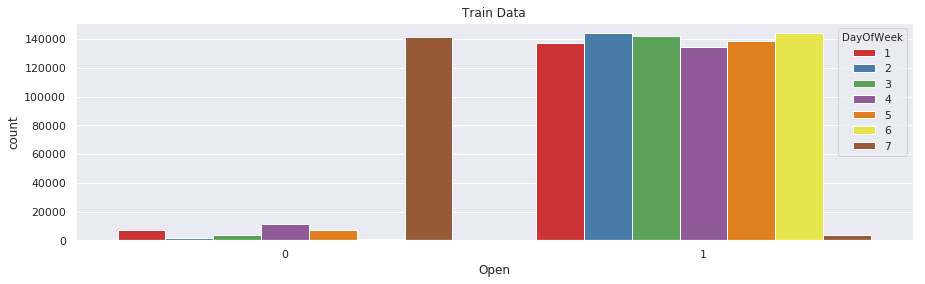

In [161]:
fig, axis = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open',hue='DayOfWeek', data=train,
              palette=sns.color_palette("Set1", n_colors=7), ax=axis)
plt.title("Train Data")

In [7]:
# getting rid of closed stores
train = train[(train.Open != 0) & (train.Sales != 0)]

As we remember: we have **11 NANs in Open column in Test Data**. 

So it's time to deal with it. First of all, we have to know, which store has this NANs. Then we will explore: when this store was closed. After that we will decide whether every NAN should have a replacing option = 0 or not. 

Text(0.5, 1.0, 'Test Data')

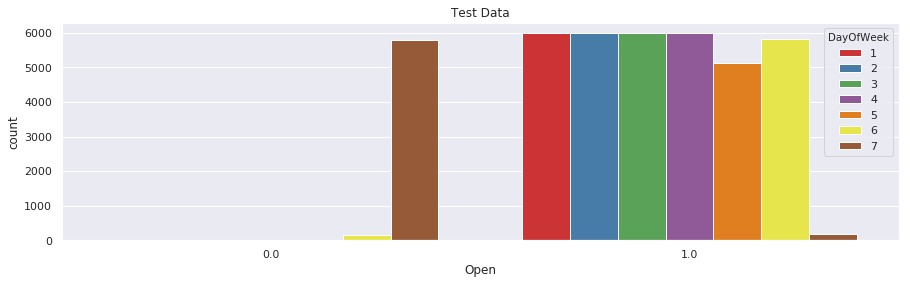

In [162]:
fig, axis = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open',hue='DayOfWeek', data=test,
              palette=sns.color_palette("Set1", n_colors=7), ax=axis)
plt.title("Test Data")

In [170]:
test[(test['Open'] != 0) & (test['Open']!=1)]

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,
2015-09-17,480,622,4,NaN,1,0,0,2015,9,17,38
2015-09-16,1336,622,3,NaN,1,0,0,2015,9,16,38
2015-09-15,2192,622,2,NaN,1,0,0,2015,9,15,38
2015-09-14,3048,622,1,NaN,1,0,0,2015,9,14,38
2015-09-12,4760,622,6,NaN,0,0,0,2015,9,12,37
2015-09-11,5616,622,5,NaN,0,0,0,2015,9,11,37
2015-09-10,6472,622,4,NaN,0,0,0,2015,9,10,37
2015-09-09,7328,622,3,NaN,0,0,0,2015,9,9,37
2015-09-08,8184,622,2,NaN,0,0,0,2015,9,8,37


Ok, that's only 622 store, that has NANs. Let's consider days with NAN :
 [1, 2, 3, 4, 5, 6]


Text(0.5, 1.0, 'Test Data for store 622')

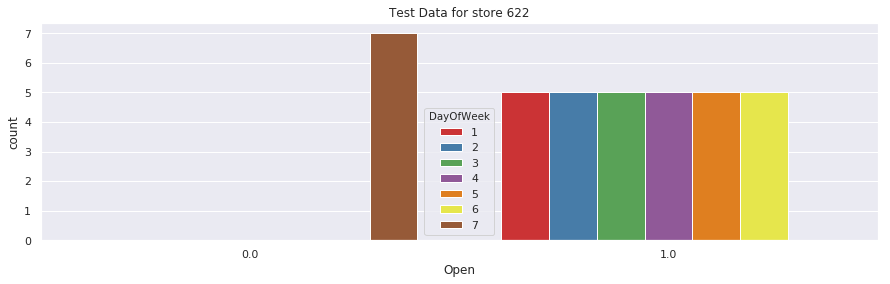

In [174]:
print("Ok, that's only 622 store, that has NANs. Let's consider days with NAN :\n", 
      sorted(test[(test['Open'] != 0) & (test['Open']!=1)].DayOfWeek.unique()))

fig, axis = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open',hue='DayOfWeek', data=test[test['Store']==622],
              palette=sns.color_palette("Set1", n_colors=7), ax=axis)
plt.title("Test Data for store 622")

Paying attention to plot with test data and open column for 622 store-> we see, that on days [1..6] this store always open. 

It leads us to **put 1 in all NANs in this data**.

In [8]:
# replacing NANs with OPEN-state
test.Open.fillna(1, inplace=True)

Now our data without useless information about closed stores. 

We can group by **date** and get **average sales**, and **percentage change** between the current and a prior element:

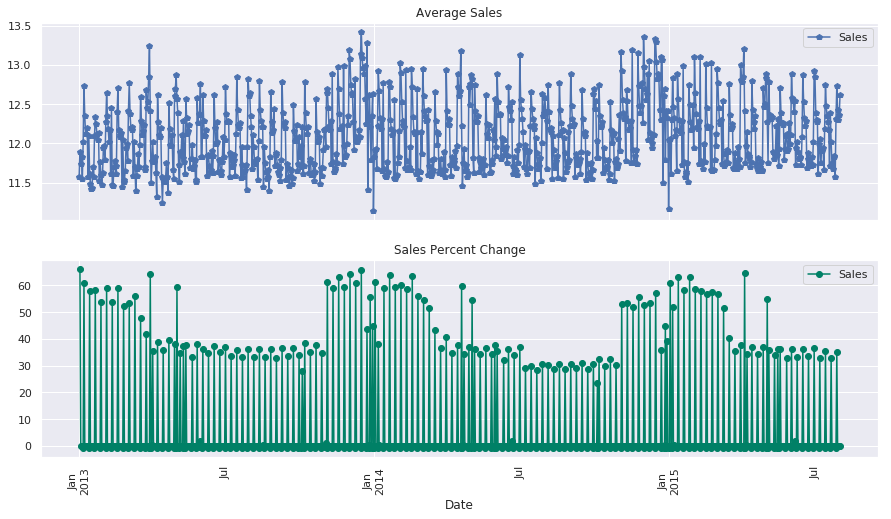

In [185]:
average_sales    = train.groupby('Date')["Sales"].mean()
pct_change_sales = train.groupby('Date')["Sales"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1, sharex=True, figsize=(15,8))

# average sales
ax1 = average_sales.plot(legend=True, ax=axis1, marker='p', title="Average Sales")
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist(), rotation=90)

# percent change for sales
ax2 = pct_change_sales.plot(legend=True,ax=axis2, marker='o', rot=90, colormap="summer", title="Sales Percent Change")

Got from this plots: clearly seeing increasing of Sales in period around NewYear, seems to be real. 

Pattern of every year Average Sales Function is repeated every year - Ok, nothing strange, nothing super interesting. 



>  ### So what about distribution of  **Sales** in different **days of week**?

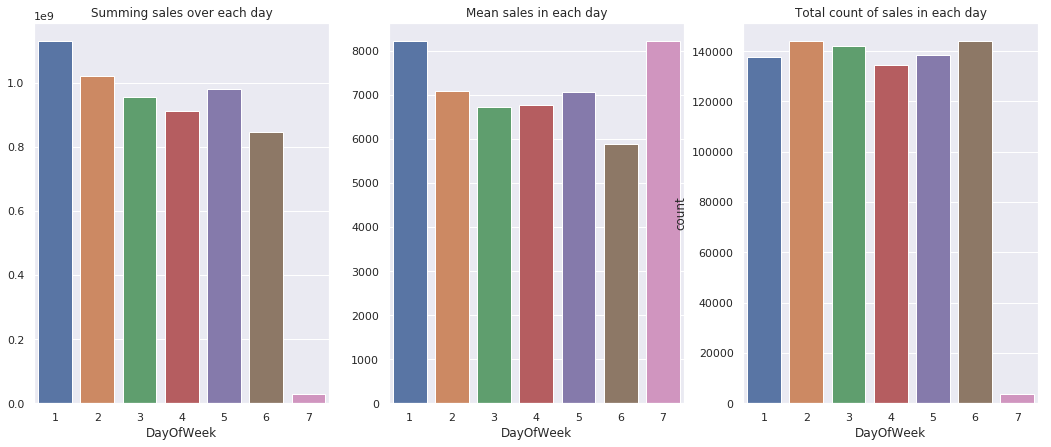

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(131)
sns.barplot(x=train.groupby('DayOfWeek')['Sales'].sum().index, y=train.groupby('DayOfWeek')['Sales'].sum().values)
ax1.set_title("Summing sales over each day")

ax2 = fig.add_subplot(132)
sns.barplot(x=train.groupby('DayOfWeek')['Sales'].mean().index, y=train.groupby('DayOfWeek')['Sales'].mean().values)
ax2.set_title("Mean sales in each day")

ax3 = fig.add_subplot(133)
sns.countplot(train.DayOfWeek)
ax3.set_title("Total count of sales in each day")

plt.rcParams['figure.figsize'] = 18, 7
sns.set(font_scale=1)

plt.show()

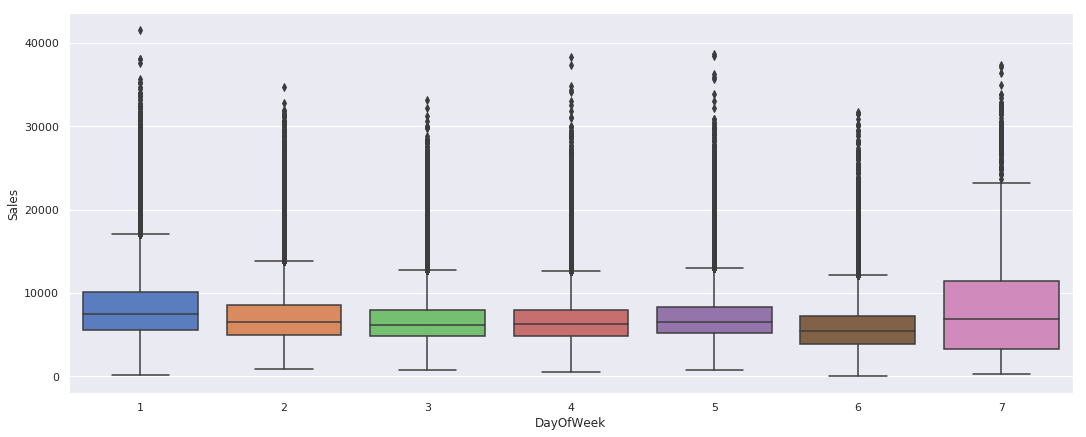

In [18]:
sns.boxplot(x='DayOfWeek', y='Sales', data=train, palette="muted");

OK, from plots we can see that highest profit is happened at 1th day.

At 7th day there is very small quantity of sales (most probably because of closed stores), but mean-sale in this day one of the highest! There are 2 leaders in "mean measure" : 1th and 7th days.

Also we can consider such interesting variable as **Promo** (whether a store is running a promo on that day or not). 

 


> ### Here we can see how depends **sales** and **customers** on every **day of week** and whether **promo** is on day or not :

			----------Dependency of Sales on DayOfWeek with/without Promo--------

1nd bar is for day with Promo, 2nd bar is for day without Promo


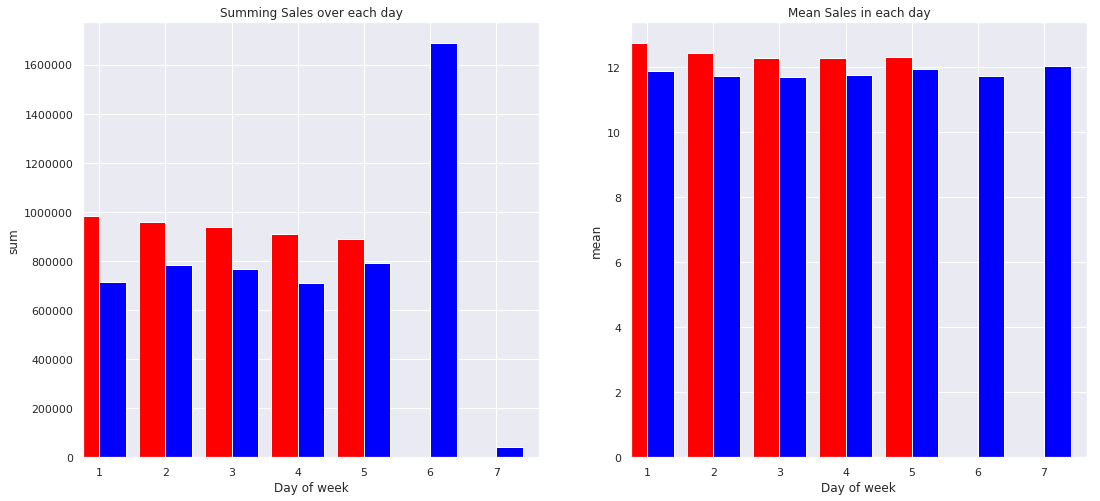

In [76]:
print("\t\t\t----------Dependency of Sales on DayOfWeek with/without Promo--------\n")
print("1nd bar is for day with Promo, 2nd bar is for day without Promo")
fig = plt.figure()
# Bar width
width = 0.4

ax1 = fig.add_subplot(121)
Day_Promo = train[train['Promo'] == 1].groupby('DayOfWeek')['Sales'].sum()
Day_NoPromo = train[train['Promo'] != 1].groupby('DayOfWeek')['Sales'].sum()
Day_Promo.plot(kind='bar', width=width, color='#FF0000', position=1, label='Day_Promo', rot=0)
Day_NoPromo.plot(kind='bar', width=width, color='#0000FF', position=0, label='Day_NoPromo', rot=0)
plt.xlabel('Day of week')
plt.ylabel('sum')
ax1.set_title("Summing Sales over each day")

ax2 = fig.add_subplot(122)
Day_Promo = train[train['Promo'] == 1].groupby('DayOfWeek')['Sales'].mean()
Day_NoPromo = train[train['Promo'] != 1].groupby('DayOfWeek')['Sales'].mean()
Day_Promo.plot(kind='bar', width=width, color='#FF0000', position=1, label='Day_Promo', rot=0)
Day_NoPromo.plot(kind='bar', width=width, color='#0000FF', position=0, label='Day_NoPromo', rot=0)
plt.xlabel('Day of week')
plt.ylabel('mean')
ax2.set_title("Mean Sales in each day")

plt.rcParams['figure.figsize'] = 18, 8
sns.set(font_scale=1)
plt.show()

			----------Dependency of Customers on DayOfWeek with/without Promo--------

1nd bar is for day with Promo, 2nd bar is for day without Promo


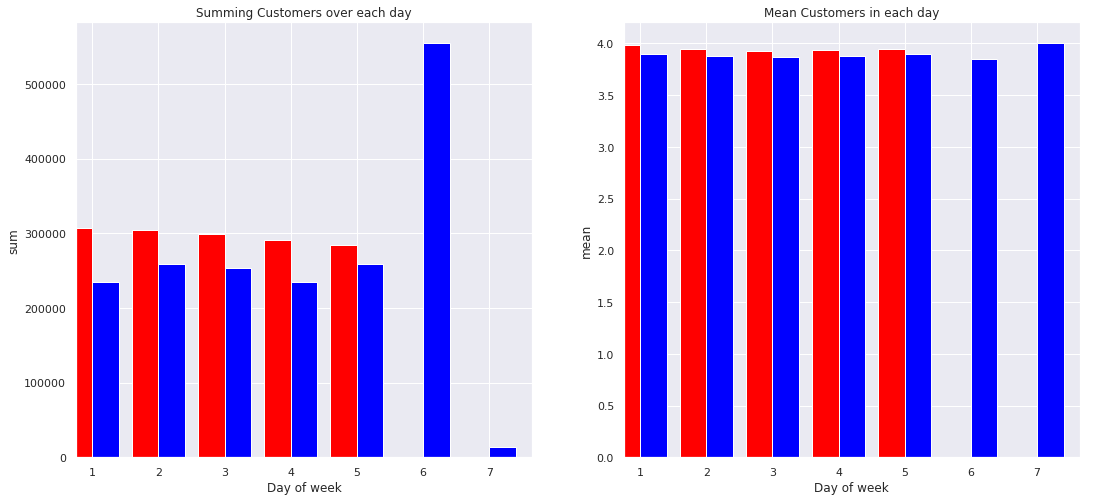

In [77]:
print("\t\t\t----------Dependency of Customers on DayOfWeek with/without Promo--------\n")
print("1nd bar is for day with Promo, 2nd bar is for day without Promo")
fig = plt.figure()
# Bar width
width = 0.4

ax1 = fig.add_subplot(121)
Day_Promo = train[train['Promo'] == 1].groupby('DayOfWeek')['Customers'].sum()
Day_NoPromo = train[train['Promo'] != 1].groupby('DayOfWeek')['Customers'].sum()
Day_Promo.plot(kind='bar', width=width, color='#FF0000', position=1, label='Day_Promo', rot=0)
Day_NoPromo.plot(kind='bar', width=width, color='#0000FF', position=0, label='Day_NoPromo', rot=0)
plt.xlabel('Day of week')
plt.ylabel('sum')
ax1.set_title("Summing Customers over each day")

ax2 = fig.add_subplot(122)
Day_Promo = train[train['Promo'] == 1].groupby('DayOfWeek')['Customers'].mean()
Day_NoPromo = train[train['Promo'] != 1].groupby('DayOfWeek')['Customers'].mean()
Day_Promo.plot(kind='bar', width=width, color='#FF0000', position=1, label='Day_Promo', rot=0)
Day_NoPromo.plot(kind='bar', width=width, color='#0000FF', position=0, label='Day_NoPromo', rot=0)
plt.xlabel('Day of week')
plt.ylabel('mean')
ax2.set_title("Mean Customers in each day")

plt.rcParams['figure.figsize'] = 18, 8
sns.set(font_scale=1)
plt.show()

Got some interesting results here. Sales on saturday without Promo really tends to peak a maximum. 
On sunday, I think, there are many closed stores - so minimum benefits. Other days : we can see, that sales on Promo-days significantlly bigger.

Interesting, that "mean-measure" of sales in Promo-Sunday doesn not have big difference from other days, but the total count of customers of this day is extralarge, and it leads total sum of sales to be bigger. 

In the beginning I was talking about obvious assumption about strong connection between **Sales** and **Customers**, now it's time to prove it precisely :

In [8]:
print("Pearson correlation : ", round(st.pearsonr(train.Customers, train.Sales)[0], 3))

Pearson correlation :  0.824


Our pearson correlation factor of 0.824 explains that there is a strong positive correlation between Sales and Customers. In general, the more customers you have in a store, the higher your sales for the day.
 

So it seems interesting to create new variable : 

In [9]:
# combinig new variable
train['SalePerCustomer'] = train['Sales'] / train['Customers']

> ### Distribution analysis of target variables:

Creating some usefull functions for distribution analysis: 

In [10]:
def norm_testing(vector):
    print("Skewness value :", np.round(st.skew(vector.values),decimals=2))
    print("The kurtosis for Fisher’s definition  :", np.round(st.kurtosis(vector.values) , decimals=2))
    print("Assymetry: ", np.abs(np.round(st.skew(vector.values),decimals=2)))
    print("Excess: ", np.abs(np.round(st.kurtosis(vector.values) ,decimals=2)))
    
    print("The kurtosis test that it's a normal distribution :", 
         "\nZ-score: {}  \nThe 2-sided p-value for the hypothesis test: {}".
         format(round(st.kurtosistest(vector.values)[0], 4), st.kurtosistest(vector.values)[1]))
    
    # for getting better accuracy in Sapiro-Wilk test, let's take from data, for example, 4500 random values
    # In documentation we can find max quantity of values for accurate results : 5000 
    vector = vector.reset_index(drop=True) #reindexing to [0,1,2,3 etc.] 
    indices = np.random.choice(a=vector.index, size=4500, replace=False)
    
    print("The Shapiro-Wilk test for the null hypothesis, that it's a normal distribution: ",
          "\nThe test statistic: {} \nThe p-value for the hypothesis test {}".
          format(round(st.shapiro(vector[indices].values)[0], 4), st.shapiro(vector[indices].values)[1]))
    

def get_distrib_stats(data):
    norm_testing(data)
    
    sns.set(rc={"figure.figsize": (20, 5)})
    sns.set(font_scale=1.2)
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    p_x = sns.distplot(data, fit=st.norm, kde=True,ax=ax1, bins=50)
    #ax1.legend()
    ax1.set_title("Probability density function")
    ax2 = fig.add_subplot(122)
    prob = st.probplot(data, dist=st.norm, plot=ax2)
    ax2.set_title('Probabilyty plot')
    #ax2.legend()
    plt.show()
    


			-----------Distribution analysis for Sales-----------
Skewness value : 1.59
The kurtosis for Fisher’s definition  : 4.85
Assymetry:  1.59
Excess:  4.85
The kurtosis test that it's a normal distribution : 
Z-score: 300.4692  
The 2-sided p-value for the hypothesis test: 0.0
The Shapiro-Wilk test for the null hypothesis, that it's a normal distribution:  
The test statistic: 0.8855 
The p-value for the hypothesis test 0.0


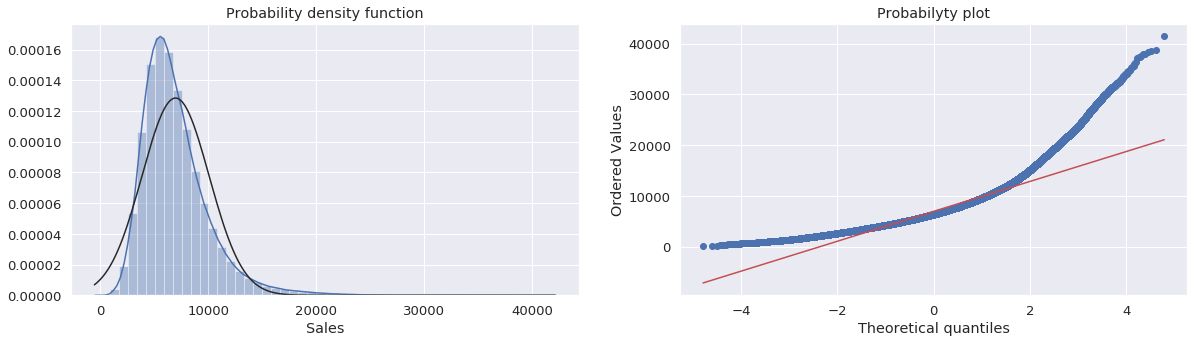

			-----------Distribution analysis for Customers-----------
Skewness value : 2.79
The kurtosis for Fisher’s definition  : 13.32
Assymetry:  2.79
Excess:  13.32
The kurtosis test that it's a normal distribution : 
Z-score: 412.8111  
The 2-sided p-value for the hypothesis test: 0.0
The Shapiro-Wilk test for the null hypothesis, that it's a normal distribution:  
The test statistic: 0.7972 
The p-value for the hypothesis test 0.0


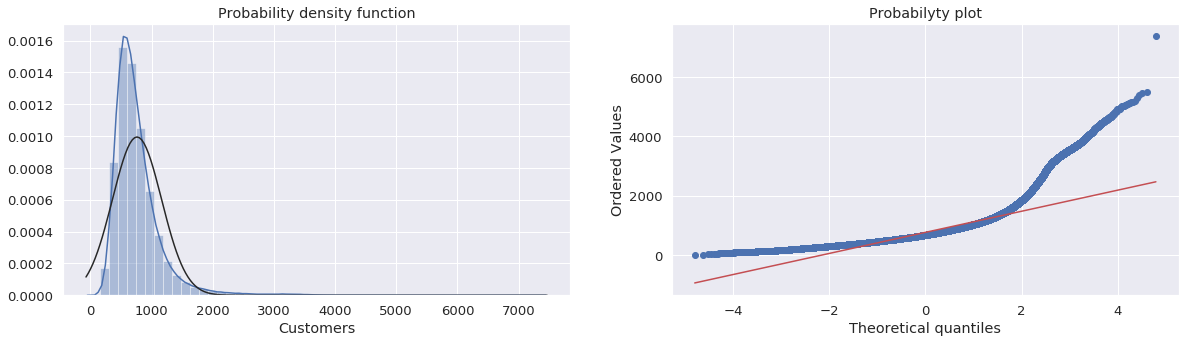

			-----------Distribution analysis for SalePerCustomer-----------
Skewness value : 0.59
The kurtosis for Fisher’s definition  : 2.76
Assymetry:  0.59
Excess:  2.76
The kurtosis test that it's a normal distribution : 
Z-score: 234.0123  
The 2-sided p-value for the hypothesis test: 0.0
The Shapiro-Wilk test for the null hypothesis, that it's a normal distribution:  
The test statistic: 0.9832 
The p-value for the hypothesis test 9.89589402453757e-23


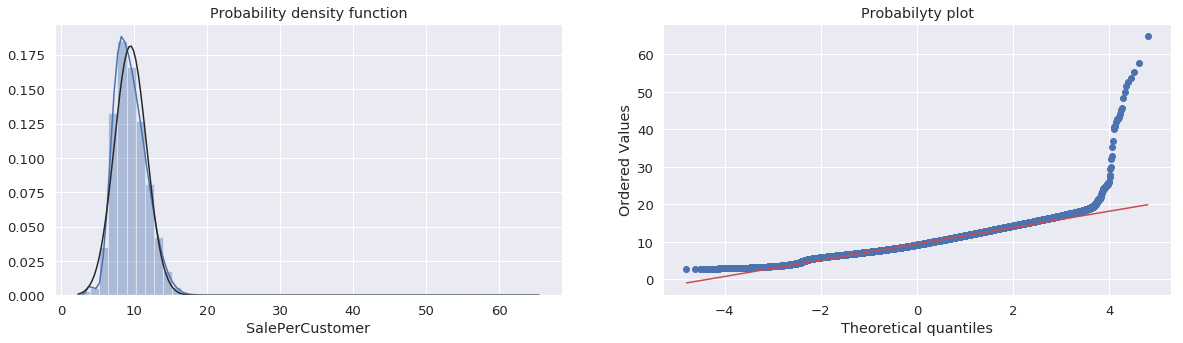

In [23]:
print("\t\t\t-----------Distribution analysis for Sales-----------")
get_distrib_stats(train['Sales'])

print("\t\t\t-----------Distribution analysis for Customers-----------")
get_distrib_stats(train['Customers'])

print("\t\t\t-----------Distribution analysis for SalePerCustomer-----------")
get_distrib_stats(train['SalePerCustomer'])


##### OK, it's not normally distributed. 

Better for our future modeling to have target variable normally distributed.

How we can deal with it : we can remove "unconvienient" values, like large tails, so it gives us a bit different picture: data seems to become closer to normal. But here we have to deal with some data leaking.
Also we can add log() function to our target and we will gain again some "improvment" in the way getting variable more normally distributed. 

For sure we can consider more different techniques, I tried many, and for "place and time" saving I will show the best way I explored this data to make variable normally distributed.

We will use **coxbox**.

But first let's look at **boxplots** of Sales and Customers: 


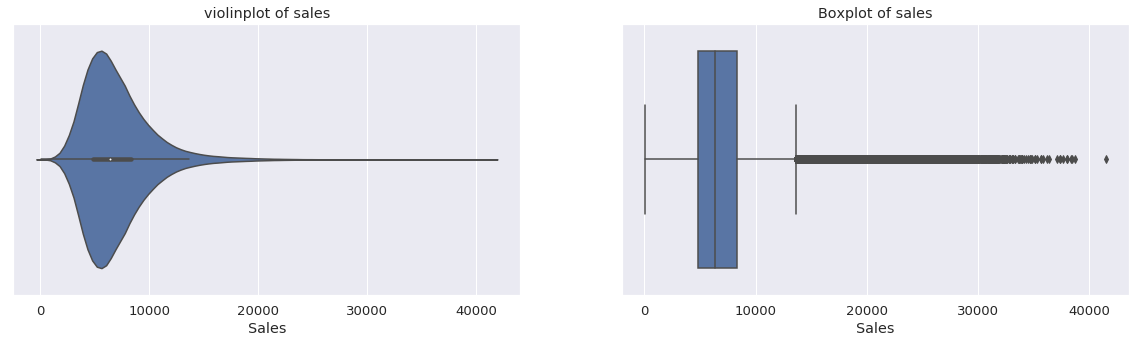

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
sns.violinplot(x='Sales', scale='count',data=train[train['Sales'] > 0])
ax1.set_title("violinplot of sales")

ax2 = fig.add_subplot(122)
sns.boxplot( x='Sales', data=train[train['Sales'] > 0], orient="h")
ax2.set_title("Boxplot of sales")

plt.rcParams['figure.figsize'] = 18, 7
sns.set(font_scale=3)

plt.show()

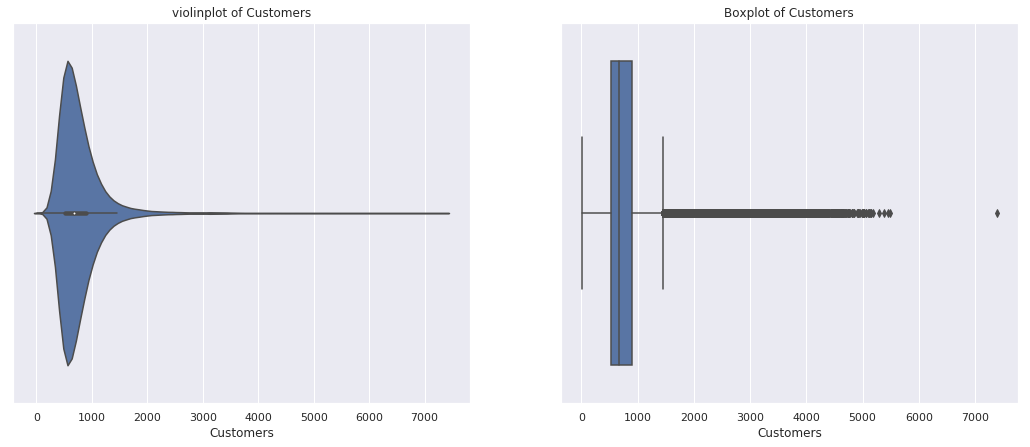

In [45]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
sns.violinplot(x='Customers', scale='count',data=train[train['Customers'] > 0])
ax1.set_title("violinplot of Customers")

ax2 = fig.add_subplot(122)
sns.boxplot( x='Customers', data=train[train['Customers'] > 0], orient="h")
ax2.set_title("Boxplot of Customers")

plt.rcParams['figure.figsize'] = 18, 7
sns.set(font_scale=1)

plt.show()

There are some outliers in target variables, so we will decide how to deal with it in next chapters. 

And now **coxboxing the target** : 

(we will also save **lambdas** from coxbox function for next usage in **inverse coxbox** function later, when prediction will be calculated, and so we will get true prediction)

In [11]:
# coxboxing and save lambdas : 
lambdas_coxbox = []

coxboxed, lam = boxcox(train['Sales'].values)
sales_coxboxed = pd.Series(coxboxed, index=train.Sales.index)
lambdas_coxbox.append(lam)

coxboxed, lam = boxcox(train['Customers'].values)
cust_coxboxed = pd.Series(coxboxed, index=train.Customers.index)
lambdas_coxbox.append(lam)

coxboxed, lam = boxcox(train['SalePerCustomer'].values)
sale_per_cust_coxboxed = pd.Series(coxboxed, index=train.SalePerCustomer.index)
lambdas_coxbox.append(lam)

print('Lambda for Sales: %f' % lambdas_coxbox[0])
print('Lambda for Customers: %f' % lambdas_coxbox[1])
print('Lambda for SalePerCustomer: %f' % lambdas_coxbox[2])


Lambda for Sales: 0.069340
Lambda for Customers: -0.173125
Lambda for SalePerCustomer: 0.353622


			-----------Distribution analysis for coxboxed Sales-----------
Skewness value : 0.01
The kurtosis for Fisher’s definition  : 0.57
Assymetry:  0.01
Excess:  0.57
The kurtosis test that it's a normal distribution : 
Z-score: 84.3933  
The 2-sided p-value for the hypothesis test: 0.0
The Shapiro-Wilk test for the null hypothesis, that it's a normal distribution:  
The test statistic: 0.9974 
The p-value for the hypothesis test 7.20592254310759e-07


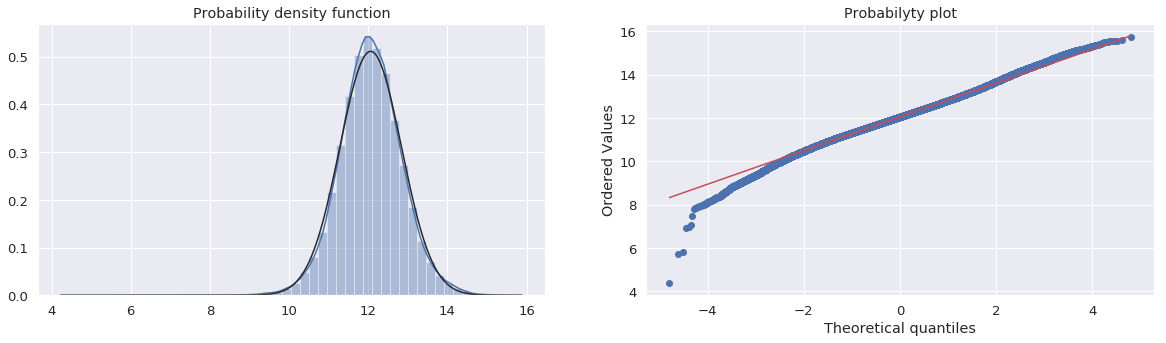

			-----------Distribution analysis for coxboxed Customers-----------
Skewness value : -0.03
The kurtosis for Fisher’s definition  : 1.07
Assymetry:  0.03
Excess:  1.07
The kurtosis test that it's a normal distribution : 
Z-score: 133.6594  
The 2-sided p-value for the hypothesis test: 0.0
The Shapiro-Wilk test for the null hypothesis, that it's a normal distribution:  
The test statistic: 0.9912 
The p-value for the hypothesis test 3.7189243600018113e-16


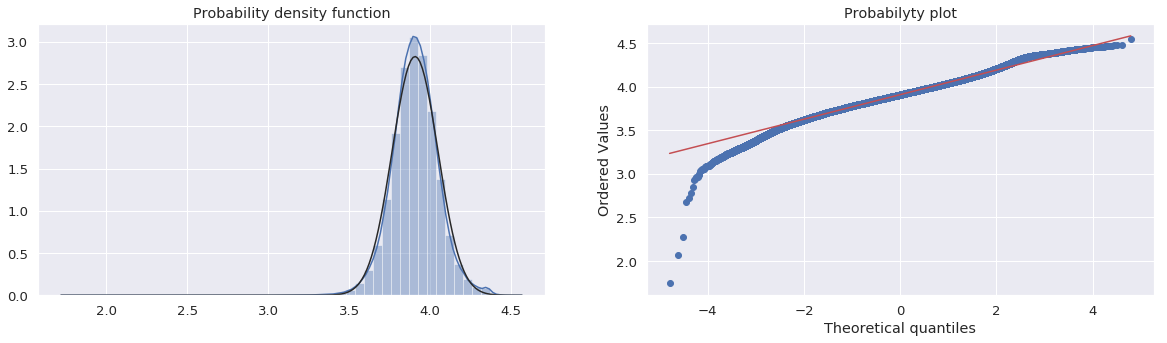

			-----------Distribution analysis for coxboxed SalePerCustomer-----------
Skewness value : 0.01
The kurtosis for Fisher’s definition  : 0.41
Assymetry:  0.01
Excess:  0.41
The kurtosis test that it's a normal distribution : 
Z-score: 63.8305  
The 2-sided p-value for the hypothesis test: 0.0
The Shapiro-Wilk test for the null hypothesis, that it's a normal distribution:  
The test statistic: 0.9956 
The p-value for the hypothesis test 2.4582183510979405e-10


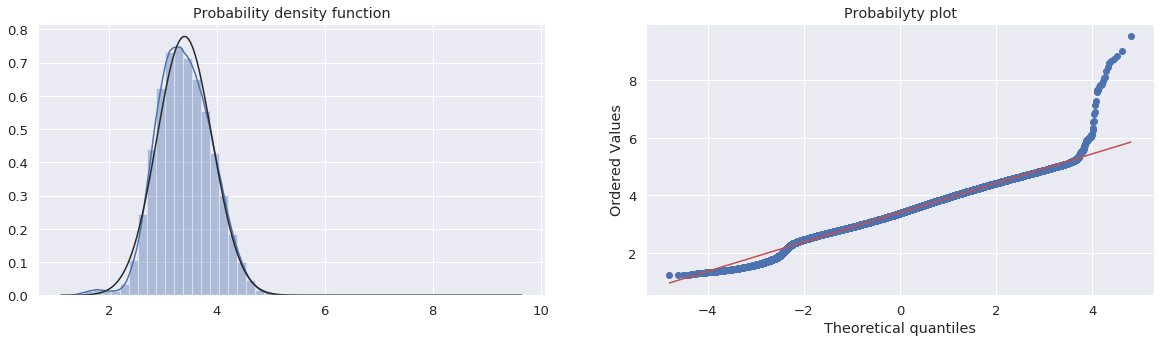

In [65]:
print("\t\t\t-----------Distribution analysis for coxboxed Sales-----------")
get_distrib_stats(sales_coxboxed)

print("\t\t\t-----------Distribution analysis for coxboxed Customers-----------")
get_distrib_stats(cust_coxboxed)

print("\t\t\t-----------Distribution analysis for coxboxed SalePerCustomer-----------")
get_distrib_stats(sale_per_cust_coxboxed)


OK, now it seems to be better. 
Also, we didn't do anything with outliers, so, perhaps, removing this values will lead us to better distribuation without leaking in accuracy of forecasting.

Let's pay attention last time for now on distribution statistics and also check, how much data we will have after **removing outliers** at all? : 

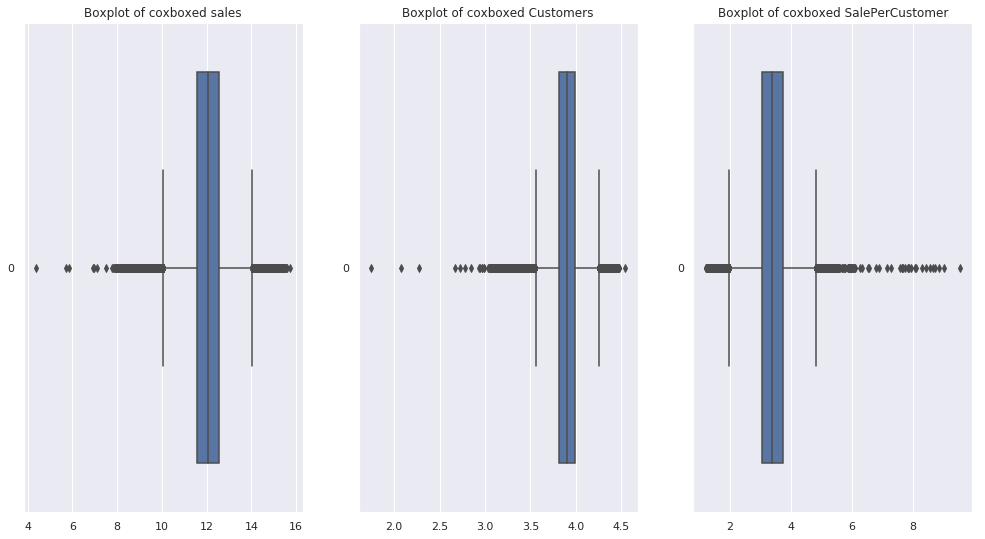

In [166]:
# finding outliers
fig = plt.figure()

ax1 = fig.add_subplot(131)
sns.boxplot(data=sales_coxboxed, orient="h")
ax1.set_title("Boxplot of coxboxed sales")

ax2 = fig.add_subplot(132)
sns.boxplot(data=cust_coxboxed, orient="h")
ax2.set_title("Boxplot of coxboxed Customers")

ax3 = fig.add_subplot(133)
sns.boxplot(data=sale_per_cust_coxboxed, orient="h")
ax3.set_title("Boxplot of coxboxed SalePerCustomer")



plt.rcParams['figure.figsize'] = 17, 14
sns.set(font_scale=1)

plt.show()

			-----------Distribution analysis for cutted coxboxed Sales-----------
Skewness value : 0.01
The kurtosis for Fisher’s definition  : 0.54
Assymetry:  0.01
Excess:  0.54
The kurtosis test that it's a normal distribution : 
Z-score: 80.1003  
The 2-sided p-value for the hypothesis test: 0.0
The Shapiro-Wilk test for the null hypothesis, that it's a normal distribution:  
The test statistic: 0.9965 
The p-value for the hypothesis test 7.86324871882016e-09


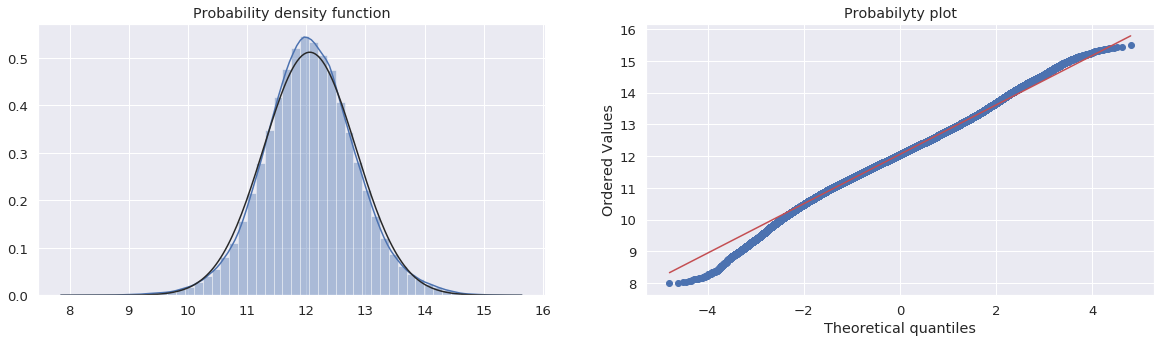

			-----------Distribution analysis for cutted coxboxed Customers-----------
Skewness value : -0.01
The kurtosis for Fisher’s definition  : 0.9
Assymetry:  0.01
Excess:  0.9
The kurtosis test that it's a normal distribution : 
Z-score: 118.5853  
The 2-sided p-value for the hypothesis test: 0.0
The Shapiro-Wilk test for the null hypothesis, that it's a normal distribution:  
The test statistic: 0.9939 
The p-value for the hypothesis test 6.712827993124448e-13


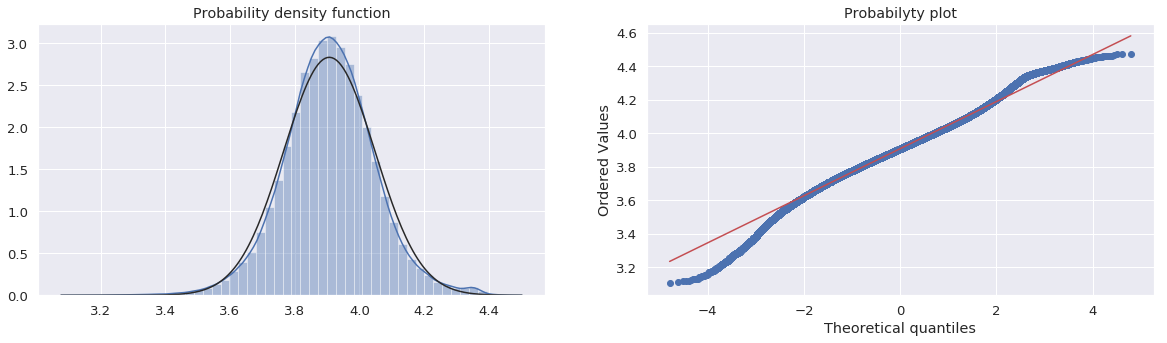

			-----------Distribution analysis for cutted coxboxed SalePerCustomer-----------
Skewness value : -0.01
The kurtosis for Fisher’s definition  : 0.21
Assymetry:  0.01
Excess:  0.21
The kurtosis test that it's a normal distribution : 
Z-score: 35.4084  
The 2-sided p-value for the hypothesis test: 1.2674128957791634e-274
The Shapiro-Wilk test for the null hypothesis, that it's a normal distribution:  
The test statistic: 0.996 
The p-value for the hypothesis test 1.079785594271243e-09


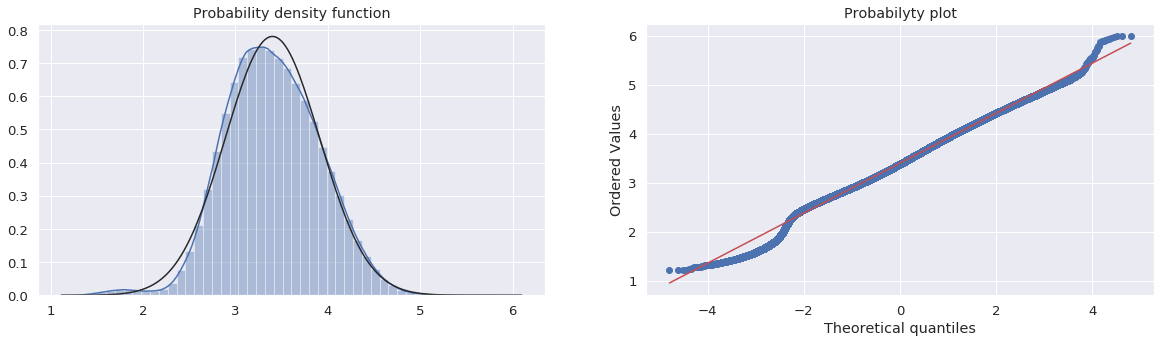

In [167]:
print("\t\t\t-----------Distribution analysis for cutted coxboxed Sales-----------")
get_distrib_stats(sales_coxboxed.where((sales_coxboxed > 8) & (sales_coxboxed < 15.5 ))
                            .sort_values().dropna())

print("\t\t\t-----------Distribution analysis for cutted coxboxed Customers-----------")
get_distrib_stats(cust_coxboxed.where((cust_coxboxed > 3.1) & (cust_coxboxed < 4.5))
                            .sort_values().dropna())

print("\t\t\t-----------Distribution analysis for cutted coxboxed SalePerCustomer-----------")
get_distrib_stats(sale_per_cust_coxboxed.where(sale_per_cust_coxboxed < 6)
                            .sort_values().dropna())


In [10]:
print("We will save :")
print("{0:.3f}% of data for Sales".format(len(sales_coxboxed.where((sales_coxboxed > 8) & (sales_coxboxed < 15.5 ))
                            .sort_values().dropna()) / len(sales_coxboxed.values)*100))

print("{0:.3f}% of data for Customers".format(len(cust_coxboxed.where((cust_coxboxed > 3.1) & (cust_coxboxed < 4.5))
                            .sort_values().dropna()) / len(cust_coxboxed.values)*100))

print("{0:.3f}% of data for SalePerCustomer".format(len(sale_per_cust_coxboxed.where(sale_per_cust_coxboxed < 6)
                            .sort_values().dropna()) / len(sale_per_cust_coxboxed.values)*100))


We will save :
99.997% of data for Sales
99.996% of data for Customers
99.996% of data for SalePerCustomer


Since we get pretty nice results, we are going to change values for all three variables in train data set, and then we will go to next part of out research: 

In [12]:
# take coxboxed values
train.Sales = sales_coxboxed
train.Customers = cust_coxboxed
train.SalePerCustomer = sale_per_cust_coxboxed

# removing outliers from each variable
print("rows before cutting : ", train.shape[0])
train = train[(train.Sales > 8) & (train.Sales < 15.5 )]
train = train[(train.Customers > 3.1) & (train.Customers < 4.5 )]
train = train[train.SalePerCustomer < 6]
print("rows after cutting : ", train.shape[0])

rows before cutting :  844338
rows after cutting :  844257


>>> ## Part 3 & Part 4. Primary visual data analysis &  Patterns, insights, peculiarities of data 

We have spent a lot of time on looking for interesting moments in target variables, and now we will start from creating new self-explanatory features and showing visual analysis.  

In [13]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

test['Year'] = test.index.year
test['Month'] = test.index.month
test['Day'] = test.index.day
test['WeekOfYear'] = test.index.weekofyear

#print("\n TRAIN ")
#nans_counter(train)
#print("\n TEST ")
#nans_counter(test)

Since we started, we didn't dive deep inside into store dataframe. 

So it's time do it: 

> ### Diving deep inside into store dataframe: 

Firstly, as I said before, we will deal with missing values. 

Then we will merge our train and test frames with information in store-df. 



We have already explored about nans : 
 **STORE**
 
Store NANs :  0

StoreType NANs :  0

Assortment NANs :  0

CompetitionDistance NANs :  3

CompetitionOpenSinceMonth NANs :  354

CompetitionOpenSinceYear NANs :  354

Promo2 NANs :  0

Promo2SinceWeek NANs :  544

Promo2SinceYear NANs :  544

PromoInterval NANs :  544


Ok, pretty obvious, that **Promo2SinceWeek**, **Promo2SinceYear** and **PromoInterval** have NANs because of zero values in Promo2: in meaning of absent continuous promotional activities for those stores. Since we understand this fact, we will just replace NANs in this columns with 0 : 

In [14]:
store.Promo2SinceWeek.fillna(0,inplace=True)
store.Promo2SinceYear.fillna(0,inplace=True)
store.PromoInterval.fillna(0,inplace=True)

Second problem - is **CompetitionDistance** NANs.

Let's explore it values and distribution : 


Mean :  5404.901079136691 
Median :  2325.0 
Standard Dev :  7659.7282732764415


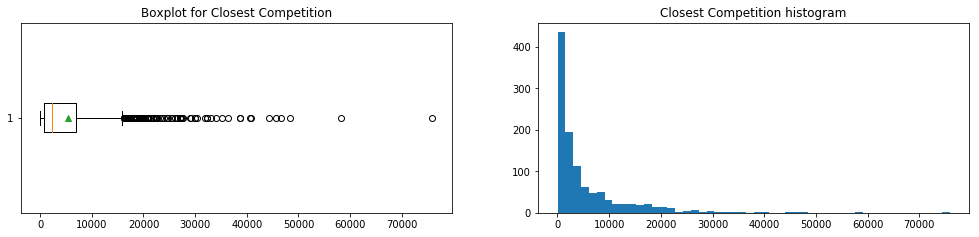

In [15]:
store_1 = store.drop(store[pd.isnull(store.CompetitionDistance)].index)
fig, axes = plt.subplots(1, 2, figsize=(17,3.5))

axes[0].boxplot(store_1.CompetitionDistance, showmeans=True, vert=False)
axes[0].set_title('Boxplot for Closest Competition')

axes[1].hist(store_1.CompetitionDistance, bins=50)
axes[1].set_title("Closest Competition histogram")

# deleting redundant Data Frame
del store_1
gc.collect()

print("Mean : ", np.nanmean(store.CompetitionDistance), 
      "\nMedian : ", np.nanmedian(store.CompetitionDistance), 
      "\nStandard Dev : ", np.nanstd(store.CompetitionDistance))

Here is a highly skewed distribution for this variable with a huge difference between the mean and the median. This being caused by the significant value of dispersion with a standard deviation of 7659, higher than the mean and the median. 

So unlike mean, the median gives us the positional center of the data so it is not influenced by outliers. And we will replace NANs with the median.


In [15]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

The last problem here - is NANs in **CompetitionOpenSinceMonth** and **CompetitionOpenSinceYear**.

The easiest way here is fullfil the fields with 0. 

More interesting way: take top Month and Year from distributions of this values in dataset, but it can lead to wrong results because of this "inaccurate" transformation. 

And the most creative way could be to apply a **multilabel classification** algorithm and train on the non Nan fields and then predict what could be most probably the month and year for those fields. 
(this idea I explored while reading the discussion and forums for this competition. I didn't find in kernels, that anyone made something like this, so this mini-task is going to be more intriguing)

> So we will try to do it with very basic algorithm and super easy feature auto selection,  because of the main purpose of this work: we are going to do research in another forecasting task, not multilabel classification. But it's interesting to do fast implementation for such NANs replacing.  

I think, it's better to do full implementation of this idea in function, returning non NAN columns, because of memory saving. 

> ### Function for multilabel classification prediction inplace NANs:

In [16]:
# mlc = multilabel classification
def mlc_fun(df, trees=1000):
    # ##### split on train and predict sets
    # taking only not NAN objects in train : 
    df_store_tr = df[df['CompetitionOpenSinceMonth'] > 0].copy()
    
    # dropping all not NAN objects from df for test:     
    df_store_te = df.copy()
    df_store_te.drop(df_store_tr.index, inplace=True, axis=0)
    print(">>>checking correction of separating on train and test: \n",
          df_store_tr.shape[0], '+', df_store_te.shape[0], "=",
          df_store_tr.shape[0] + df_store_te.shape[0], "== full length:", df.shape[0])
        
    # taking store values for merge and the end
    store_tr = df_store_tr.Store.values
    store_te = df_store_te.Store.values
    
    # taking true target varibales for train. And store column for merge dataframes later 
    y_1_2_true = df_store_tr[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Store']]
    
    # we will not use Store column in prediction - so drop it. Also drop target columns
    df_store_tr.drop(columns=['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Store'], inplace=True)
    df_store_te.drop(columns=['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Store'], inplace=True)
    
    # ##### separating target for mini-preprocessing
    y_1 = y_1_2_true.CompetitionOpenSinceMonth
    y_2 = y_1_2_true.CompetitionOpenSinceYear
    
    # taking unique monthes that exist in train set
    monthes_ = ["month{}".format(i) for i in sorted(y_1.unique())]
    # dict for replace values in target with "str"type ones
    d1 = {k: v for (k,v) in zip(range(1,13), monthes_)}
    # inverse dict for de-code the predicted target in future 
    d1_ = {v: k for (k,v) in zip(range(1,13), monthes_)}  
    y_1 = y_1.map(d1)
    
    # taking unique years that exist in train set
    years_ = ["year{}".format(i) for i in sorted(y_2.unique())]
    # dict for replace values in target with "str"type ones
    d2 = {k: v for (k,v) in zip(sorted(y_2.unique()), years_)}
    # inverse dict for de-code the predicted target in future 
    d2_ = {v: k for (k,v) in zip(sorted(y_2.unique()), years_)}
    y_2 = y_2.map(d2)

    # full stack target vectors 
    Y_ = np.vstack((y_1, y_2)).T
    # memory cleaning 
    del y_1, y_2
    gc.collect()

    # ##### super fast feature generating and coding
    print(">>>getting dummies")
    # union of train and test for getting dummies
    train_objs_num = len(df_store_tr)
    dataset = pd.concat(objs=[df_store_tr, df_store_te], axis=0)
    dataset_preprocessed = pd.get_dummies(dataset)
    df_store_tr_dum = dataset_preprocessed[:train_objs_num]
    df_store_te_dum = dataset_preprocessed[train_objs_num:]
    # memory cleaning 
    del dataset_preprocessed, dataset, train_objs_num
    gc.collect()
    
    #df_store_tr_dum = pd.get_dummies(df_store_tr)
    #df_store_te_dum = pd.get_dummies(df_store_te)
    
    # ##### implementing easy model for classification ot multi target
    print(">>>starting classification model")
    forest = RandomForestClassifier(n_estimators=trees, random_state=17)
    multi_target_forest = MultiOutputClassifier(forest, n_jobs=4)
    y_pred = multi_target_forest.fit(df_store_tr_dum, Y_).predict(df_store_te_dum)
    
    # ##### forming convinient view of predicted values
    print(">>>prediction Done. \nReturning...")
    y_pred_ = df_store_te_dum.copy()
    y_pred_['CompetitionOpenSinceMonth'] = y_pred.T[0]
    y_pred_['CompetitionOpenSinceYear'] = y_pred.T[1]
    y_pred_.drop(columns=df_store_te_dum.columns, inplace=True)
    # getting back store column
    y_pred_['Store'] = store_te
    
    # decoding with inverse dicts
    y_pred_.CompetitionOpenSinceMonth = y_pred_.CompetitionOpenSinceMonth.map(d1_)
    y_pred_.CompetitionOpenSinceYear = y_pred_.CompetitionOpenSinceYear.map(d2_)
    
    # concatinate true target and predicted
    full_target = pd.concat([y_pred_, y_1_2_true])
    
    # ##### creating new dataframe for returning option
    df_store_new_1 = df.copy()
    df_store_new_1.drop(columns=['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], inplace=True)
    df_store_new_2 = pd.merge(df_store_new_1, full_target, how = 'left', on = 'Store')
    
    # memory cleaning 
    del df_store_new_1, full_target, y_pred_, y_1_2_true, d1 ,d2, d1_, d2_
    del df_store_tr, df_store_te, store_tr, store_te, df_store_tr_dum, df_store_te_dum
    del forest, multi_target_forest
    gc.collect()
    
    return(df_store_new_2)



Ok, function is ready. Let's just check it's accuracy of this prediction function on train data. 

For sure, it won't be high quality prediction, but I think, that if it is better than 0% - the initial idea of implementing classification wasn't for nothing! Because if we put just zeros inplace of NANs - it's around zero significance.

So the statement is our **multilabel classification function has some importance!**

For proving this this we will take existing values and replace them with 0, then we will compare results.

In [27]:
%%time
# take only existing values
store_check = store[store['CompetitionOpenSinceMonth'] > 0].copy()

# random choicing values that will be put 0
indc = store_check.index
indc_r = np.random.choice(a=indc, size=int(len(indc)*0.2), replace=False)

# saving true target
y_true = store_check.loc[indc_r, ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']]

# creating "pseudo NANs"
store_check.loc[indc_r, 'CompetitionOpenSinceMonth'] = 0 
store_check.loc[indc_r, 'CompetitionOpenSinceYear'] = 0

# get prediction
store_check_new = mlc_fun(store_check, 10000)

# checking for evaluation
print("for CompetitionOpenSinceMonth : ")
check = y_true.CompetitionOpenSinceMonth == store_check_new.loc[indc_r, 'CompetitionOpenSinceMonth']
check_count = check.apply(lambda x: 1 if x==True else 0)
print("rigth", sum(check_count), "of", len(indc_r), "=> accuracy =", round(sum(check_count)/len(indc_r)*100, 2), "%")

print("for CompetitionOpenSinceYear: ")
check = y_true.CompetitionOpenSinceYear == store_check_new.loc[indc_r, 'CompetitionOpenSinceYear']
check_count = check.apply(lambda x: 1 if x==True else 0)
print("rigth", sum(check_count), "of", len(indc_r), "=> accuracy =", round(sum(check_count)/len(indc_r)*100, 2), "%")

# cleaning memory
del store_check, store_check_new, indc, indc_r, check, check_count
gc.collect()

>>>checking correction of separating on train and test: 
 609 + 152 = 761 == full length: 761
>>>getting dummies
>>>starting classification model
>>>prediction Done. 
Returning...
for CompetitionOpenSinceMonth : 
rigth 17 of 152 => accuracy = 11.18 %
for CompetitionOpenSinceYear: 
rigth 18 of 152 => accuracy = 11.84 %
CPU times: user 10.3 s, sys: 4.81 s, total: 15.1 s
Wall time: 33.7 s


As expected, we got **greater then 0 accuracy prediction!** Alright, it's super small for good classification, but we will go with this implemention and predict "classes" for true NANs.

I think, this idea is really good, and here we have large space for make something creative and wellpredicting. But for this step, it's enough. We can always back here and change something for model improvment.

And now we are going to the next point.

It would better not rewrite the store-df. Perhaps, we will use both in some model later and check which one better. 


In [17]:
%%time
# random forest with 10k estimators 
store_mlc = mlc_fun(store, 10000)



>>>checking correction of separating on train and test: 
 761 + 354 = 1115 == full length: 1115
>>>getting dummies
>>>starting classification model
>>>prediction Done. 
Returning...
CPU times: user 8.47 s, sys: 4.92 s, total: 13.4 s
Wall time: 30.3 s


In [22]:
# save it if you want
# store_mlc.to_csv(os.path.join(PATH_TO_alldata, "store_mlc.csv"), index=False)

In [153]:
# checking is there any NAN
nans_counter(store_mlc)

Store NANs :  0
StoreType NANs :  0
Assortment NANs :  0
CompetitionDistance NANs :  0
Promo2 NANs :  0
Promo2SinceWeek NANs :  0
Promo2SinceYear NANs :  0
PromoInterval NANs :  0
CompetitionOpenSinceMonth NANs :  0
CompetitionOpenSinceYear NANs :  0


Now it's clean, no NANs in store-df! 

Since train and store DFs are ready for every kind of analysis, we will start from merging them!


In [154]:
df_train_store_mlc = pd.merge(train, store_mlc, how = 'left', on = 'Store')

# all the time we make similar actions with test data
df_test_store_mlc = pd.merge(test, store_mlc, how = 'left', on = 'Store')

> ### Analysis Sales with respect to CompetitionDistance :

I think, it's important charactristic, supposing, that stores without near competitors have significantly more sales then other stores.  

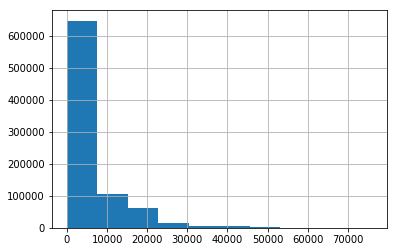

In [34]:
analysis_comp_dist = df_train_store_mlc.loc[:, ['CompetitionDistance', 'Sales', 'Customers']].copy()
analysis_comp_dist.CompetitionDistance.hist()

Ok, let's split CompetitionDistance for 5-6 parts and then look on AVERAGE of Sales and Customers:

In [35]:
analysis_comp_dist['CompetitionDist_cut'] = pd.cut(analysis_comp_dist['CompetitionDistance'], 5)
print("for Sales: ", analysis_comp_dist.groupby(by="CompetitionDist_cut").Sales.mean())
print("Customers: ", analysis_comp_dist.groupby(by="CompetitionDist_cut").Customers.mean())

del analysis_comp_dist
gc.collect()

for Sales:  CompetitionDist_cut
(-55.84, 15188.0]     12.060022
(15188.0, 30356.0]    12.081289
(30356.0, 45524.0]    11.888769
(45524.0, 60692.0]    11.814917
(60692.0, 75860.0]    12.302961
Name: Sales, dtype: float64
Customers:  CompetitionDist_cut
(-55.84, 15188.0]     3.909732
(15188.0, 30356.0]    3.887487
(30356.0, 45524.0]    3.866431
(45524.0, 60692.0]    3.871778
(60692.0, 75860.0]    3.979150
Name: Customers, dtype: float64


35

We can state that the stores that are the furthest have the highest average sales and number of customers. 

But it is not so significant difference from the stores that have their competitors not so far.

Anyway, if there are no competition nearby, stores tend to sell more and have more customers because there are almost a monopoly in this region. 

> ### Analysis Sales, Customers and SalePerCustomer with respect to Store Type :

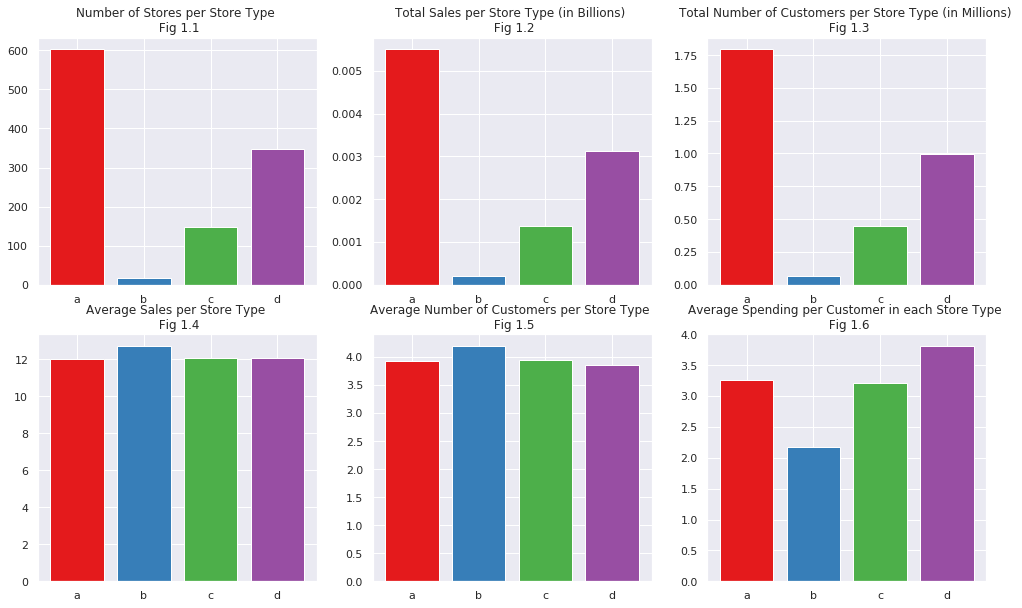

In [190]:
fig, axes = plt.subplots(2, 3,figsize=(17,10))
palette = itertools.cycle(sns.color_palette("Set1", n_colors=4))
clrs = [next(palette),next(palette),next(palette),next(palette)]

axes[0,0].bar(store_mlc.groupby(by="StoreType").count().Store.index, 
              store_mlc.groupby(by="StoreType").count().Store, color=clrs)
axes[0,0].set_title("Number of Stores per Store Type \n Fig 1.1")

axes[0,1].bar(df_train_store_mlc.groupby(by="StoreType").sum().Sales.index,
              df_train_store_mlc.groupby(by="StoreType").sum().Sales/1e9, color=clrs)
axes[0,1].set_title("Total Sales per Store Type (in Billions) \n Fig 1.2")

axes[0,2].bar(df_train_store_mlc.groupby(by="StoreType").sum().Customers.index,
              df_train_store_mlc.groupby(by="StoreType").sum().Customers/1e6, color=clrs)
axes[0,2].set_title("Total Number of Customers per Store Type (in Millions) \n Fig 1.3")

axes[1,0].bar(df_train_store_mlc.groupby(by="StoreType").sum().Customers.index,
              df_train_store_mlc.groupby(by="StoreType").Sales.mean(), color=clrs)
axes[1,0].set_title("Average Sales per Store Type \n Fig 1.4")

axes[1,1].bar(df_train_store_mlc.groupby(by="StoreType").sum().Customers.index,
              df_train_store_mlc.groupby(by="StoreType").Customers.mean(), color=clrs)
axes[1,1].set_title("Average Number of Customers per Store Type \n Fig 1.5")

axes[1,2].bar(df_train_store_mlc.groupby(by="StoreType").sum().Sales.index,
              df_train_store_mlc.groupby(by="StoreType").SalePerCustomer.mean(), color=clrs)
axes[1,2].set_title("Average Spending per Customer in each Store Type \n Fig 1.6")

plt.show()

From Fig 1.1 - Fig 1.3 We can see that Storetype A has the highest number of stores, sales and customers 

From Fig 1.4 - Fig 1.5 we got that Storetype B has the highest average Sales and highest average Number of Customers. 

Figure 1.6 tells us who has the highest average spending per Customer - it's StoreType D. Perhaps, this happened because no more similair shops around.

Let's describe an **Assortment** level:

> ### Analysis of Assortments with respect to Store Type :

StoreType  Assortment
a          a             381
           c             221
b          a               7
           b               9
           c               1
c          a              77
           c              71
d          a             128
           c             220
Name: Assortment, dtype: int64

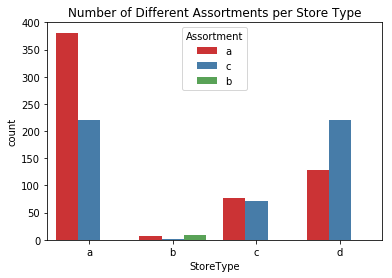

In [57]:
sns.countplot(x="StoreType",hue="Assortment",order=["a","b","c","d"], 
                                     data=store_mlc,
                                     palette=sns.color_palette("Set1", n_colors=3))\
                          .set_title("Number of Different Assortments per Store Type")

store_mlc.groupby(by=["StoreType","Assortment"]).Assortment.count()

From both barplot and counting it is clearly to see. that almosr all of the stores have either 'a' assortment type or 'c', and 'b' type is only 9 stores!


Talking about extra variety of products, we can say, that store type 'D' has the highest Sales per customer average actually and has mostly 'c' assortment type. This leads us to the reason of for having this high average in Sales per customer. Having variery in stores always increases the customers spending pattern.


Also we can state another important fact: store type 'B' is the only one who has the 'b' assortment type ("extra variety"), looking at fig 1.4 and 1.5 exactly this store type has the highest number of customers and sales. It means, that having in the store not so much variety of products like 'c' assortment and not too basic like 'a' assortment will reach the high traffic in this store.


We already saw the connection between **Sales and date in chapter 2**, there was common usuall pattern. Next step in exploring this theme is to look on connection between **Sales and Promotion withrespect to date**.

> ### Analysis of Sales and Promotion withrespect to date:


			 Sales with Promotion1,Promotion2 withrespect to date



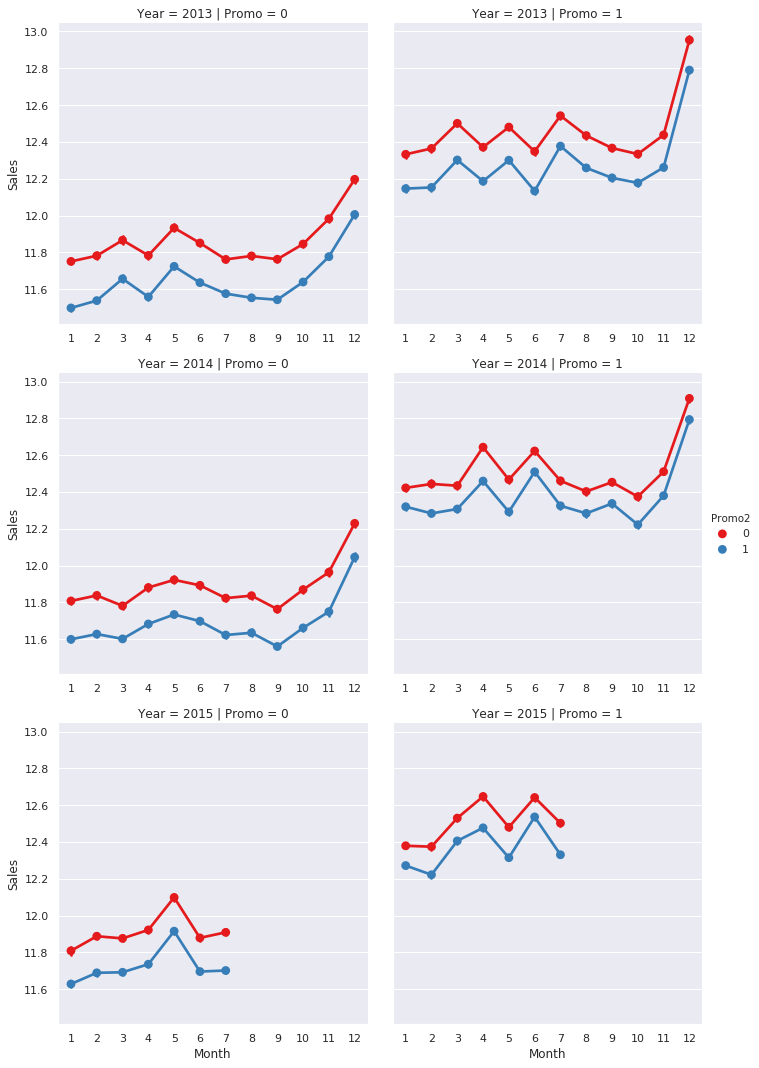

In [180]:
print("\n\t\t\t Sales with Promotion1,Promotion2 with respect to date\n")
sns.factorplot(data = df_train_store_mlc, x ="Month", y = "Sales", col = 'Promo', hue = 'Promo2', row = "Year", 
               sharex=False, palette=sns.color_palette("Set1", n_colors=2))


			 SalePerCustomer with Promotion1,Promotion2 with respect to date



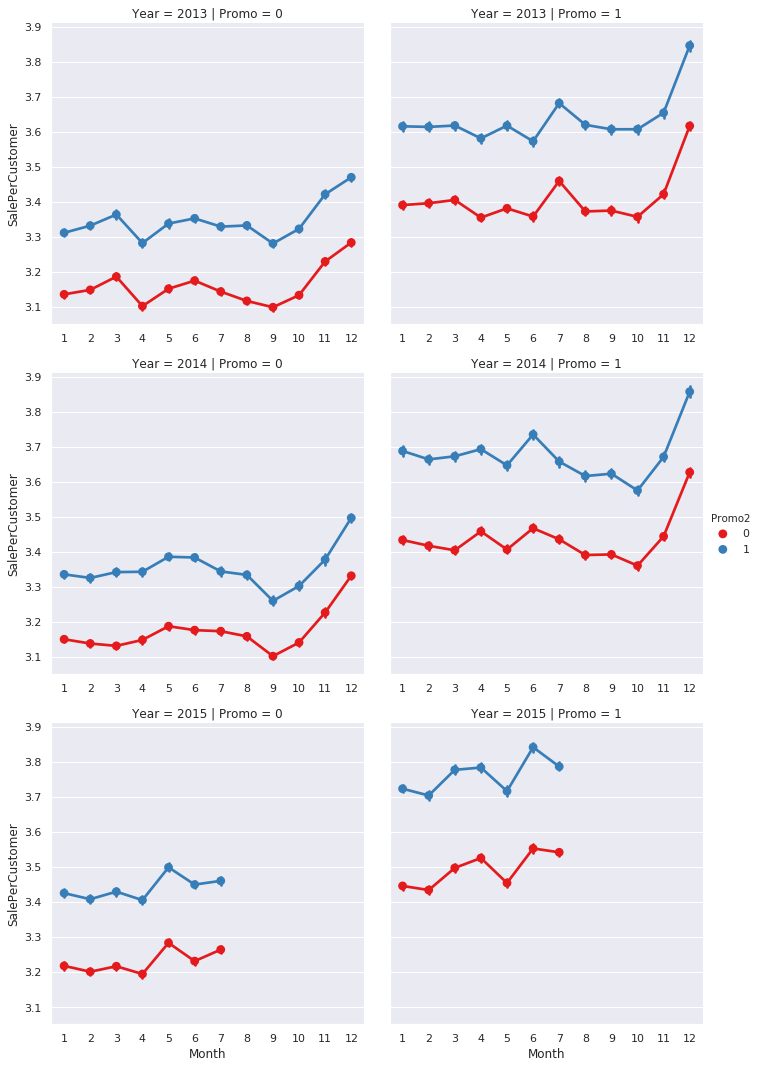

In [181]:
print("\n\t\t\t SalePerCustomer with Promotion1,Promotion2 with respect to date\n")
sns.factorplot(data = df_train_store_mlc, x ="Month", y = "SalePerCustomer", col = 'Promo', hue = 'Promo2', 
               row = "Year", sharex=False, palette=sns.color_palette("Set1", n_colors=2))

It is easy to see, here is a considerable difference between having promotion and not having. It means, that promotion really helps stores to change their amounts of sales to greater one.

Another fact we can claim is the Promo2 variable, indicating a contunious promotion, works as "inverse" factor of promotion: in general, when there is no consecutive promotion, stores tend to sell more, then with consecutive promotion. Not so obvious, but we can suppose, that continous promotion is added for stores with very low sales to attract to attend customers. So those continuous promotion shows a tremending increase in the buying energy of customers.


Looking through years there is a slight increase of total sales year over year. And as we already told on chapter2, there is a similair pattern in the months over the years with major pikes around the Christmas and Easter periods, in the 2/3 of Summer, and in March and April.

And finally look at **Sales per day of week with respect to Promo**:

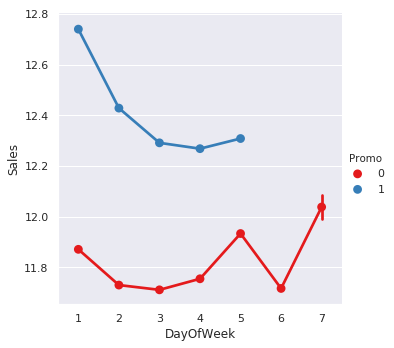

In [192]:
sns.factorplot(data = df_train_store_mlc, x ="DayOfWeek", y = "Sales", hue='Promo' , sharex=False, 
               palette=sns.color_palette("Set1", n_colors=2))

In [155]:
print ("Number of Stores are opened on Sundays: ", 
       df_train_store_mlc[(df_train_store_mlc.Open == 1) & (df_train_store_mlc.DayOfWeek == 7)]
       ['Store'].unique().shape[0])

Number of Stores are opened on Sundays:  33


No Promo on holidays. And on sundays work very few of stores. So this peak on 7th day of the week is normal, because of, perhaps, free time people having. So that's really important for stores to be opened on Sundays.

Also there is a peak on Mondays with promotions, a tiny peak on Friday before the weekend.

> ### Correlation Analysis 

First of all, we need numerical variables for our correlation analysis, so we have to transform not numerical variables to a numerical representation without leaking their logic.

We remember that we have such variable as Open column. Since we have deleted all rows with zeros in this column (because of no profit for future model), now we can remove this column at all. 

In [156]:
df_train_store_mlc.drop(columns='Open', inplace=True)

# also in test : 
df_test_store_mlc.drop(columns='Open', inplace=True)

In [157]:
print("Let's check what types of variables we have : \n\n", df_train_store_mlc.dtypes)

Let's check what types of variables we have : 

 Store                          int64
DayOfWeek                      int64
Sales                        float64
Customers                    float64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
SalePerCustomer              float64
Year                           int64
Month                          int64
Day                            int64
WeekOfYear                     int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
dtype: object


We have PromoInterval, StoreType, Assortment and StateHoliday as Obejcts.  

For correlation functions, we need to make float variables. So we will create additional DF for this analysis.

Thus we will transform it to category type, then we will get codes and set up type as float : 

But for modeling we will get dummies from categories - so just transform objects to categoires.



In [158]:
df_train_store_mlc['StateHoliday'] = df_train_store_mlc['StateHoliday'].astype('category')
df_train_store_mlc['Assortment'] = df_train_store_mlc['Assortment'].astype('category')
df_train_store_mlc['StoreType'] = df_train_store_mlc['StoreType'].astype('category')
df_train_store_mlc['PromoInterval'] = df_train_store_mlc['PromoInterval'].astype('category')
# there are some 0 are INT, so we will convert it to str : 
df_train_store_mlc.StateHoliday = df_train_store_mlc.StateHoliday.apply(lambda x: '0' if x==0 else x)


df_correlation = df_train_store_mlc[['Store', 'DayOfWeek', 'Sales', 'Customers', 'Promo', 'SchoolHoliday', 
                               'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
                               'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SalePerCustomer', 'Month', 
                               'Year', 'Day', 'StateHoliday', 'Assortment', 'StoreType', 'PromoInterval']]

df_correlation['StateHoliday_cat'] = df_correlation['StateHoliday'].cat.codes.astype('float')
df_correlation['Assortment_cat'] = df_correlation['Assortment'].cat.codes.astype('float')
df_correlation['StoreType_cat'] = df_correlation['StoreType'].cat.codes.astype('float')
df_correlation['PromoInterval_cat'] = df_correlation['PromoInterval'].cat.codes.astype('float')


In [169]:
# the same for test : 
df_test_store_mlc['StateHoliday'] = df_test_store_mlc['StateHoliday'].astype('category')
df_test_store_mlc['Assortment'] = df_test_store_mlc['Assortment'].astype('category')
df_test_store_mlc['StoreType'] = df_test_store_mlc['StoreType'].astype('category')


/usr/local/lib/python3.5/site-packages/seaborn/palettes.py:777: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.



11327

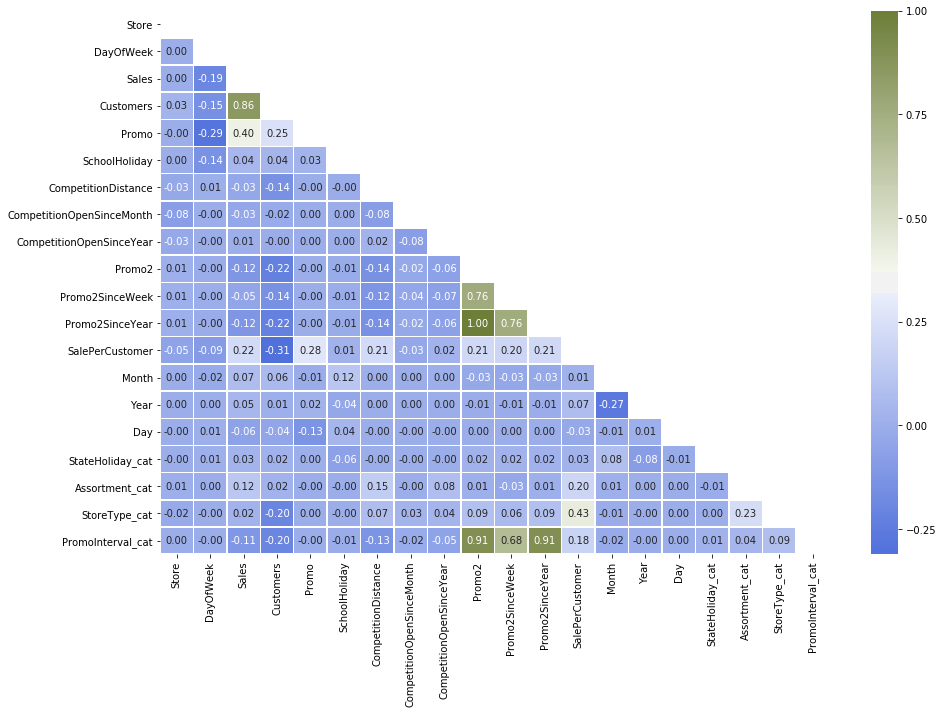

In [124]:
upper_triangle = np.zeros_like(df_correlation.corr(), dtype = np.bool)
upper_triangle[np.triu_indices_from(upper_triangle)] = True 

f, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(df_correlation.corr(), ax=ax, mask=upper_triangle, annot=True, fmt='.2f', 
            linewidths=0.5, cmap=sns.diverging_palette(-100, 100, as_cmap=True))

# cleaning
del df_correlation
gc.collect()

> So what have we got? 

There is a huge correlation with value 0.86 between Customers and Sales as we supposed before.

Also significant value has Promo with Sales =0.4, since running a promotion increases that number .

We can talk also about correlation between SalePerCustomers and Sales, but it's obvious and this variable is not available in test set.

Furthermore, Assortment category with Sales has the 3rd place : 0.12

Finally, we can see that StoreType does play a major role with SalePerCustomer = 0.43, this is probably due to the encoding of the store type variable.

At this stage, we got a solid understanding of the distributions, the statistical properties and the relationships of our variables. The next step is to get clear with the metric for our model. 

>>> ## Part 5. Metrics selection

One of the most difficult issues is the question of choosing the most appropriate measures out of the groups. Due to the fact that each error measure has the disadvantages that can lead to inaccurate evaluation of the forecasting results, it is impossible to choose only one measure. 

In this competition we already have metric for model evaluation. Its' RMSPE. Let's consider it closer.

In the begining there was definition: Root Mean Square Percentage Error (RMSPE). 
<center>
<img src="https://habrastorage.org/webt/kq/pz/hx/kqpzhxo3app_0yojqxkxa42uzx0.png" />
where ${y_i}$ denotes the sales of a single store on a single day and ${y(hat)_i}$ denotes the corresponding prediction. Any day and store with 0 sales is ignored in scoring. 


We will take RMSPE, because of several reasons : 
On of the reasons is that this measure don't  depend on the magnitudes of the demand variables being predicted. 

Usually there is an appearance division by zero when the actual value is equal to zero. But as we remember, we already have got rid of all zeros in dataset. So it's not a problem for us now.

So what about interpretation of this measure? 

> RMSPE: Forecasting Power

> < 10%:	Highly accurate forecasting

> 10–20%:	Good forecasting

> 20–50%:	Resonable forecasting

> more than 50%:	Inaccurate forecasting

As you remember, I transformed the target variable Sales, SalePerCustomer, and Customers
: they were coxboxed. So let's define function for inverse coxbox, using lambdas_coxbox defined early:

In [264]:
# lambdas_coxbox: [0] Sales, [1] Customers, [2] SalePerCustomer

"""
# troubles with xgboost

def ToWeight(y):
    w = np.zeros(y.num_row(), dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe
"""

def rmspe(y, yhat):
    return np.sqrt(np.mean((1 - yhat/y) ** 2))


def rmspe_inv_cb(y, yhat, lambda_coxbox):
    
    y = inv_boxcox(y, lambda_coxbox)
    yhat = inv_boxcox(yhat, lambda_coxbox)
    
    return rmspe(y, yhat)


>>> ## Part 6. Model selection

For this competition we will try : RandomForestRegressor. 

This models should have good results because of the data: it's based on time series. 

So firstly, we will train models and fit using GridSearch for hyperparameter optimization to make a prediction. Also we will check results on hold-out sets. 

For sure, we can explore such models as LightGBM or NeuralNetworks, but for starting point it's enough.

> RandomForest is a machine learning alogrithm used for classification and regression that is usually used with structured and tabular data. Its advantages:

Random forest runtimes are quite fast, and they are able to deal with unbalanced and missing data.
The process of averaging or combining the results of different decision trees helps to overcome the problem of overfitting.
They also do not require preparation of the input data. You do not have to scale the data.

> Its disadvantages:

The main drawback of Random Forests is the model size. You could easily end up with a forest that takes hundreds of megabytes of memory and is slow to evaluate.
They get a bit harder to interpret than regular deicison trees, since we are constructing of forest of more than 50 decision trees and more using grid search.


P.S. I wanted to compare results with Xgboost, but some troubles appeared: it's hard to get values from xgboost Dmatrix - so no simple way to define user scoring function. So I left it for next time, and here I will explore only Random Forest. 

In [188]:
# RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=10, 
                             criterion= 'mse', 
                             max_depth=5, 
                             n_jobs=7,
                             random_state=17, 
                             warm_start=False)



>>> ## Part 7. Data preprocessing

While exploring data and finding its percularities - we have already made some preprocessing : 

- Done work with all NANs: 
 - - In additional store : 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear' - Multilabel classification inplace of NANs.
 - - In test set Open NANs were replaced with 1 because of analysis particular store.
 - - Competition distance NANs were replaced with median of this variable. 
 
- Removed redudant column (Open), firstly got rid of zero rows in train set.

- Coxboxed target Sales and really important variable Customers.

- Some variables were transformed to categories.

- Removed outliers. 

- Created new features such a Day, Month, etc.

- Merged train and test sets with additional info in store DF. 

- All cleaning actions that we made for train set - we made for test set similarly.

Now we will continue creating some new features and cleaning of the data.

Firstly, let's condsider this columns : 

> Since the competition variables **CompetitionOpenSinceYear and CompeitionOpenSinceMonth** have the same underlying meaning, merging them into one variable that we call CompetitionOpenSince makes easier for the algorithm to understand the pattern and creates less branches and thus complex trees.



In [173]:
df_train_store_mlc['CompetitionOpenSince'] = np.where((df_train_store_mlc['CompetitionOpenSinceMonth']==0) & 
                                  (df_train_store_mlc['CompetitionOpenSinceYear']==0) , 0,
                                  (df_train_store_mlc.Month - df_train_store_mlc.CompetitionOpenSinceMonth) + 
                                  (12 * (df_train_store_mlc.Year - df_train_store_mlc.CompetitionOpenSinceYear)))
df_train_store_mlc.drop(columns=['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'], inplace=True)

# the same for test 
df_test_store_mlc['CompetitionOpenSince'] = np.where((df_test_store_mlc['CompetitionOpenSinceMonth']==0) & 
                                  (df_test_store_mlc['CompetitionOpenSinceYear']==0) , 0,
                                  (df_test_store_mlc.Month - df_test_store_mlc.CompetitionOpenSinceMonth) + 
                                  (12 * (df_test_store_mlc.Year - df_test_store_mlc.CompetitionOpenSinceYear)))
df_test_store_mlc.drop(columns=['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'], inplace=True)

> **The StateHoliday** is not very important to distinguish (what type of holiday) and can be merged in a binary variable called is_holiday_state.

In [174]:
df_train_store_mlc["is_holiday_state"] = df_train_store_mlc['StateHoliday'].map({"0": 0, "a": 1, "b": 1, "c": 1})
df_train_store_mlc.drop(columns=['StateHoliday'], inplace=True)

# the same for test 
df_test_store_mlc["is_holiday_state"] = df_test_store_mlc['StateHoliday'].map({"0": 0, "a": 1, "b": 1, "c": 1})
df_test_store_mlc.drop(columns=['StateHoliday'], inplace=True)

> It's better when working with decision tree based models to have dummy variables instead of categorical with different levels, because this alters the bias of the algorithm who will favor a higher weight to the categories like 4 and deprioritize levels like 1. And this problem could rise in the variables **Assortment and StoreType and PromoInterval**. So we will use the get_dummies function to instead do a binary encoding , as I said before.

In [176]:
df_train_store_mlc = pd.get_dummies(df_train_store_mlc, columns=["Assortment", "StoreType","PromoInterval"], 
                              prefix=["is_Assortment", "is_StoreType","is_PromoInteval"])


# the same for test 
df_test_store_mlc = pd.get_dummies(df_test_store_mlc, columns=["Assortment", "StoreType","PromoInterval"], 
                              prefix=["is_Assortment", "is_StoreType","is_PromoInteval"])


> Also let's get dummies from **Day of Week**: 


In [177]:
df_train_store_mlc  = pd.get_dummies(df_train_store_mlc, columns=['DayOfWeek'], prefix='Day')

# the same for test 
df_test_store_mlc = pd.get_dummies(df_test_store_mlc, columns=['DayOfWeek'],prefix='Day')

In [178]:
# separating variables and target . dropping target from train .
y = df_train_store_mlc.Sales.values
all_vars_close_to_target = df_train_store_mlc[['Sales', 'Customers', 'SalePerCustomer']]

df_train_store_mlc.drop(columns=['Sales', 'Customers', 'SalePerCustomer'], inplace=True)


> Now we will divide out train set on **80% training and 20% validation**.


In [179]:
X_train, X_train_test, y_train, y_train_test = train_test_split(df_train_store_mlc, y, 
                                                                test_size=0.2, random_state=17)

>>> ## Part 8. Cross-validation and adjustment of model hyperparameters


Let's start with RandomForestRegressor that we defined before.

The	main parameters we will tune for RF is the number of trees and the size of the random subsets of features to consider when splitting a node. Also we will consider max_depth.

We will use	10 fold cross validation to get RMSPE while varying these parameters. Choosing 10 K-Folds makes sure we went through all of the data and didn't miss any pattern. 




In [322]:
# we will check here what will be for initial RFR. Just for starting point. 

rfr = RandomForestRegressor(n_estimators=10, 
                             criterion='mse', 
                             max_depth=5, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             bootstrap=True, 
                             oob_score=False,
                             n_jobs=4,
                             random_state=31, 
                             verbose=0, 
                             warm_start=False)

rfr_fin.fit(df_train_store_mlc, y)
pred_1 = rfr_fin.predict(df_test_store_mlc)

pred_2_inv_cb = inv_boxcox(pred_1, lambdas_coxbox[0])
sample_submission_1 = sample_submission.copy()
sample_submission_1.Sales = pred_1_inv_cb

sample_submission_1.to_csv("subm1.csv", index=False)

# ok Here we got on LB : 0.36. Bad results.

In [323]:
# Let's tune! 

In [301]:
params = {'max_depth':(4,6,8,10,12,14,16,20),
         'n_estimators':(4,8,16,24,48,72,96,128),
         'min_samples_split':(2,4,6,8,10)}

grid = RandomizedSearchCV(estimator=rfr,param_distributions=params,cv=10) 
grid.fit(X_train, y_train)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
           oob_score=False, random_state=31, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': (4, 8, 16, 24, 48, 72, 96, 128), 'max_depth': (4, 6, 8, 10, 12, 14, 16, 20), 'min_samples_split': (2, 4, 6, 8, 10)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [324]:
#This is the best combination : 

grid.best_params_, grid.best_score_


({'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 128},
 0.8557370457047726)

> We will check this model for valid set and test on LB in next chapters 

>>> ## Part 9. Creation of new features and description of this process

We already created many new features before, here we will look on their importances.

Let's consider feature importances:

[0.19088754 0.19338141 0.00264355 0.00398943 0.00632354 0.02269513
 0.02752452 0.23002596 0.00199575 0.03188922 0.04444892 0.07301364
 0.00110459 0.02331108 0.00050717 0.00263514 0.01875604 0.02105227
 0.01079731 0.00861779 0.0047059  0.0031988  0.00490481 0.00748299
 0.02592547 0.00307957 0.00093882 0.00066058 0.004587   0.02165841
 0.00725765]


Text(0.5, 1.0, 'Feature Importance')

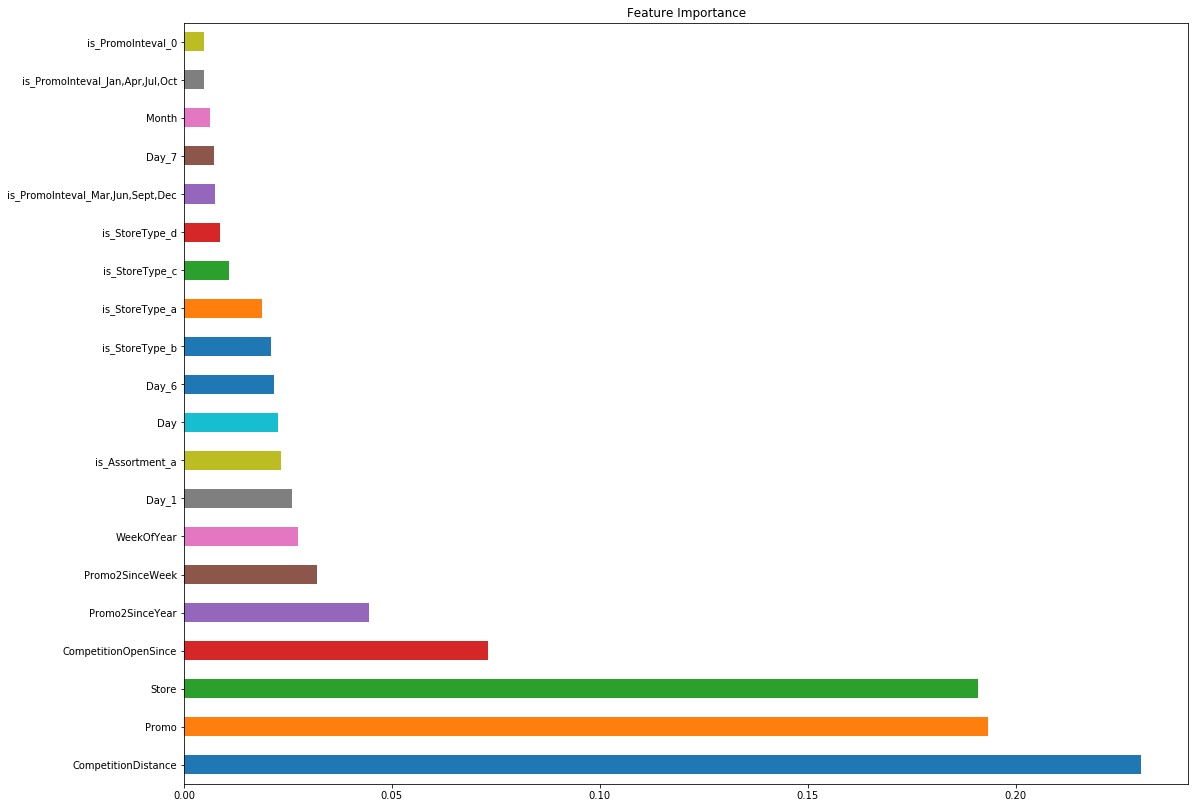

In [276]:
print(rfr_fin.feature_importances_)
plt.figure(figsize=(18, 14))
(pd.Series(rfr_fin.feature_importances_, index=X_train.columns)
   .nlargest(20)
   .plot(kind='barh'))
plt.title('Feature Importance') # top 20 features

Our top 5-6 most important variables are:

1-Competitor Distance: This indeed impacts a lot the sales of a store like we saw previously in our EDA,when competition is very far stores tend to sell a lot more.

2-Promo: Promotion is primordial for a store to increase its sales, it allows price breaking and thus more customers intersted in buying.

3-Store: The Store itself represents a unique identificator for the algorithm to recognise which store has what attributes and indeed better accounts for the forecasting of those same stores in a future timeline.

4-CompetitionOpenSince: The merging of this variable paid out and allowed us to give more accurate predicitions of the sales based on the time of opening of those competitors.

5-6 -Promo2 Since week and Year: maybe it would better to convert them to one variable. 

>>> ## Part 10. Plotting training and validation curves 

In [327]:
# Got this functions from git and a bit improved


def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
    
def plot_validation_curve_gscv(gscv, param, logx=False):
    plot_func = plt.semilogx if logx else plt.plot
    res = gscv.cv_results_
    x = [p[param] for p in res['params']]

    # minus - neg-mse to mse
    mu, std = -res['mean_train_score'], res['std_train_score']
    lines = plot_func(x, mu, label='train')
    plt.fill_between(x, mu - std, mu + std, edgecolor='none', facecolor=lines[0].get_color(), alpha=0.2)

    # minus - neg-mse to mse
    mu, std = -res['mean_test_score'], res['std_test_score']
    lines = plot_func(x, mu, label='test')
    plt.fill_between(x, mu - std, mu + std, edgecolor='none', facecolor=lines[0].get_color(), alpha=0.2)
    plt.legend()
    plt.grid(True)
    
def plot_learning_curve(reg, train_sizes, X, y):
    scoring_fun = make_scorer(rmspe, greater_is_better=False)
    N_train, val_train, val_test = learning_curve(reg,  X, y, 
                                                  train_sizes=train_sizes, 
                                                  cv=KFold(n_splits=3, shuffle=True, random_state=17),
                                                  n_jobs=-1, scoring=scoring_fun)
    
    plot_with_err(N_train, -val_train, label='training scores')
    plot_with_err(N_train, -val_test, label='validation scores')
    plt.xlabel('Training Set Size'); 
    plt.ylabel('rmspe')
    plt.legend()
    plt.grid(True)

In [328]:
plot_validation_curve_gscv(grid, 'max_depth')
plot_validation_curve_gscv(grid, 'n_estimators')
plot_validation_curve_gscv(grid, 'min_samples_split')
        

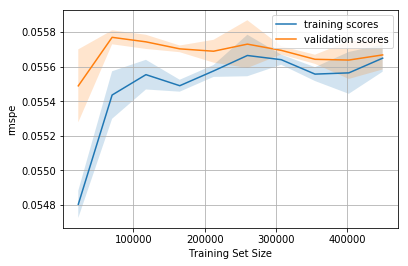

In [321]:
train_sizes = np.linspace(0.05, 1, 10)
plot_learning_curve(rfr, train_sizes, X_train, y_train)

>>> ## Part 11. Prediction for test or hold-out samples 




In [282]:
rfr_val=RandomForestRegressor(n_estimators=128, 
                             criterion='mse', 
                             max_depth=20, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             bootstrap=True, 
                             oob_score=False,
                             n_jobs=7, 
                             random_state=17, 
                             verbose=0, 
                             warm_start=False)
model_RF_test=rfr_val.fit(X_train,y_train)

yhat=model_RF_test.predict(X_train_test)


In [289]:
error=rmspe_inv_cb(y_train_test, yhat, lambdas_coxbox[0])
print(round(error, 5))

0.17903


> #### Valid score : 0.17903

## The results on the LB score 

In [294]:
df_test_store1 = df_test_store_mlc.copy()
kaggle_yhat = model_RF_test.predict(df_test_store1)

kaggle_preds = pd.DataFrame({'Id': sample_submission['Id'], 'Sales': inv_boxcox(kaggle_yhat, lambdas_coxbox[0])})
kaggle_preds.to_csv("submission_3.csv", index = False)

In [298]:
#kaggle_preds_ = pd.read_csv("submission_3.csv")
#kaggle_preds_



> #### Private Score : 0.16961

> #### Public Score: 0.15653

> Nice results I think. But much more we can implement here. The best solution of this competition was around 0.1. So it encourages me. 

>>> ## Part 12. Conclusions


We made pretty huge data analysis. 

Some interesting ideas were implemented such as multilabel classification for NANs, and here we have really big space for improving model.

Unfortunately, I didn't have enough time to deal with some problems with Xgboost, so it's good way developing and improving the solution. So we explored only RandomForest, and next points will be : discover results of Xgboost, LightGBN and perhaps NN. So it's really wotrh trying more models next time. And then compare the results. 

So maybe I will create some kind of own Xgboost and then test the results :)

We can understand from this project the flexibility and robustness of a decision tree based model like RandomForest which helped us predict the Store Sales of Rossman based on attributes that defines each store and its surroundings.

As we can see, it always delivers a good predicition score while not having a lot of modifications and difficulties capturing the patterns hidden in the data. Fortunately we had a train set that was large enough for it to converge but in general RandomForest performs not so bad on small sets since its resampling method (bagging) and its random production of trees allow the bias to remain not so high. 


I can notice that there are many ways to build new features - and it's really interesting and challenging. This steps that I covered - are the basis for my future analyses. And also I think that using hyperparameter optimization techniques like Gridsearch and RandomizedSearch is crucial to any Machine Learning problem since it allows the algorithm to not just limit itself on its defaulted parameters but to discover new opportunities of combining those parameters to reach a local optima while training on the data.
